This notebook is suited for simulations on a set of several glaciers, e.g a special set in the Himalaya (RGI60-13)

# Option 1

In this workflow, the intend is to calibrate the glen parameter A to be the closest from the one of the consensus or of Millan observations.

In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm as colormap
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import climate, massbalance, flowline

import pandas as pd
import geopandas as gpd
import numpy as np
from oggm.shop import bedtopo,gcm_climate

import add_data
import work_tasks
import graph

cfg.initialize(logging_level='WARNING')
cfg.PATHS['working_dir'] =  '/home/lucillegimenes/oggm-workflow-b/'
cfg.PARAMS['use_multiprocessing']=True
# We tell OGGM to continue despite of errors
cfg.PARAMS['continue_on_error'] = True

# The RGI version to use
# Size of the map around the glacier.
prepro_border = 80
# Degree of processing level. This is OGGM specific and for the shop 1 is the one you want
from_prepro_level = 3

2021-12-02 10:00:35: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-12-02 10:00:35: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-12-02 10:00:35: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-12-02 10:00:36: oggm.cfg: Multiprocessing switched ON after user settings.
2021-12-02 10:00:36: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


## 1. "Collecting" all the glaciers from the basin


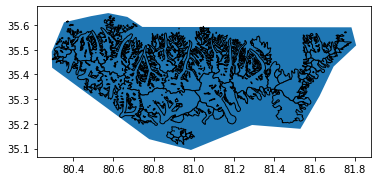

In [2]:
path_test='/home/lucillegimenes/set_himalaya.shp'
basin = gpd.read_file(path_test)

fr = utils.get_rgi_region_file(14) 
gdf = gpd.read_file(fr)

fr2 = utils.get_rgi_region_file(13) 
gdf2 = gpd.read_file(fr2)

gdf_tot=pd.concat([gdf,gdf2],axis=0)

import shapely.geometry as shpg
in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
          (x, y) in zip(gdf_tot.CenLon, gdf_tot.CenLat)] #nb in brackets has to be the index in loc above

gdf_sel = gdf_tot.loc[in_bas]

ax=basin.plot()
gdf_sel.plot(ax=ax, edgecolor='k');

In [3]:
sel=gdf_sel["RGIId"]
rgi_ids=sel.values.tolist()

In [4]:
len(rgi_ids)

444

### Filtering the number of glaciers for their area 

In [5]:
#Reducing the set the the largest glaciers
smaller=gdf_sel.loc[gdf_sel['Area']<=40,:]
bigger= gdf_sel.loc[gdf_sel['Area']>40,:]
sel=bigger["RGIId"]
rgi_main=sel.values.tolist()
len(rgi_main)

20

In [6]:
#Statistics
a_b=bigger[['Area']].sum(axis=0)[0]
ratio_b=a_b/(gdf_sel[['Area']].sum(axis=0)[0])*100
ratio_b #Percentage of the total area  of the set represented by the selected glaciers

71.15963642198457

In [ ]:
rgi_ids=rgi_main

## (1.1) Get Millan volume (don't need to be run again)

In [104]:
gdirs = workflow.init_glacier_directories(rgi_ids,
                                          from_prepro_level=from_prepro_level,
                                          prepro_base_url=base_url,
                                          prepro_border=prepro_border)

2021-11-26 16:48:19: oggm.workflow: init_glacier_directories from prepro level 3 on 63 glaciers.
2021-11-26 16:48:19: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 63 glaciers


In [51]:
for gdir in gdirs[1:]:

    gdir.name_corr=gdir.name.replace('/','-')
    if (gdir.name==''):
        gdir.name_corr=gdir.rgi_id

    #Little adjustment  
    if (gdir.rgi_region in ['13','14','15']):
        gdir.rgi_region_m='13-15'
    else:
        gdir.rgi_region_m=gdir.rgi_region

    add_data.add_data_thickness(gdir,'/home/lucillegimenes/Bureau/THICKNESS_Millan/RGI-'+gdir.rgi_region_m+'/per_glacier/'+gdir.rgi_id+'_thickness_2010.tif',
                               'millan_thickness_2010','Ice thickness from 2010')
 
    
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()

    #new dataframe to add
    vol=int(ds.millan_thickness_2010.where(ds.glacier_mask==1).sum())*(int(ds.y[0]-ds.y[1])**2)
    columns=['volume_m3']
    index=[gdir.rgi_id]
    df=pd.DataFrame(data=vol,index=index,columns=columns)
    df.index.name='RGIId'

    old=pd.read_hdf('/home/lucillegimenes/volumes_millan_13_spe_set_2010.h5')

    new=pd.concat([old,df],axis=0)

    #save 
    store = pd.HDFStore('volumes_millan_13_spe_set_2010.h5')
    store.put('dataset_01', new)
    store.close()


### Checking if everything alright, compairing the volumes from the different years

Getting informative plots (on the whole set, not just the biggest glaciers)

In [106]:
df2000=pd.read_hdf('/home/lucillegimenes/volumes_millan_13_spe_set_2000.h5')
df2018=pd.read_hdf('/home/lucillegimenes/volumes_millan_13_spe_set.h5')
df2010=pd.read_hdf('/home/lucillegimenes/volumes_millan_13_spe_set_2010.h5')

df2018_sp=df2018.loc[rgi_ids]
df2010_sp=df2010.loc[rgi_ids]
df2000_sp=df2000.loc[rgi_ids]

df_both=pd.concat([df2000_sp,df2010_sp,df2018_sp],axis=1)
df_both.columns=['volume_2000','volume_2010','volume_2018']

In [126]:
new_spe_set=gdf_sel.loc[gdf_sel['RGIId'].isin(rgi_ids)]
x=new_spe_set['Area'].to_list()

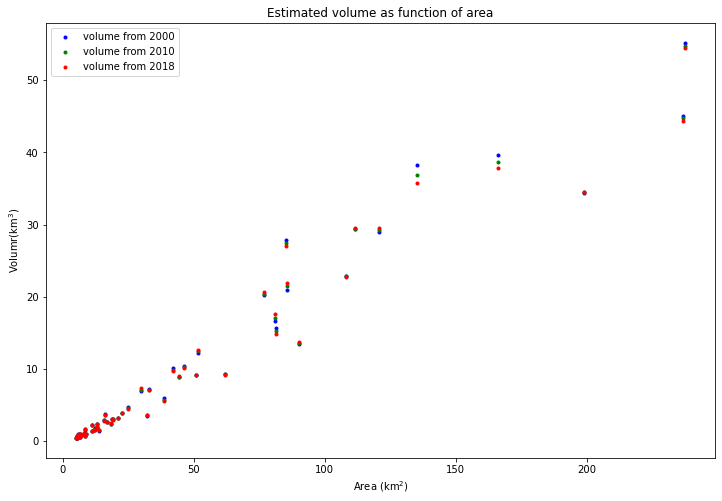

In [110]:
f, ax= plt.subplots(figsize=(12, 8))

plt.plot(x,(df_both['volume_2000']*10**-9).to_list(),'bo',label='volume from 2000',markersize=3)
plt.plot(x,(df_both['volume_2010']*10**-9).to_list(),'go',label='volume from 2010',markersize=3)
plt.plot(x,(df_both['volume_2018']*10**-9).to_list(),'ro',label='volume from 2018',markersize=3)
plt.legend()          
plt.title('Estimated volume as function of area')
plt.xlabel('Area ($\mathregular{km^2}$)')
plt.ylabel('Volumr($\mathregular{km^3}$)')

name = 'Himalaya_volume_comp_years.png'
#plt.savefig(name, format = 'png')


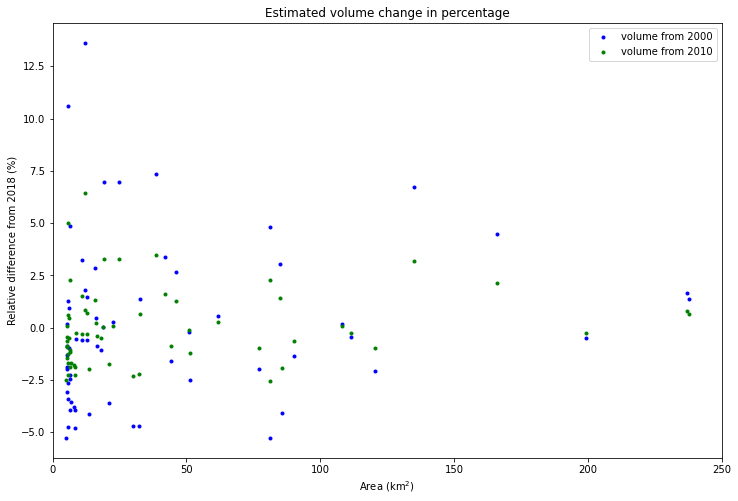

In [111]:
f, ax= plt.subplots(figsize=(12, 8))

diff2000=(df_both['volume_2000']-df_both['volume_2018'])/df_both['volume_2018']*100
diff2010=(df_both['volume_2010']-df_both['volume_2018'])/df_both['volume_2018']*100

plt.plot(x,diff2000.to_list(),'bo',label='volume from 2000',markersize=3)
plt.plot(x,diff2010.to_list(),'go',label='volume from 2010',markersize=3)

plt.legend()          
plt.title('Estimated volume change in percentage')
plt.xlabel('Area ($\mathregular{km^2}$)')
plt.ylabel('Relative difference from 2018 (%)')
plt.xlim([0,250])
name = 'Himalaya_volume_years_perc.png'
#plt.savefig(name, format = 'png')

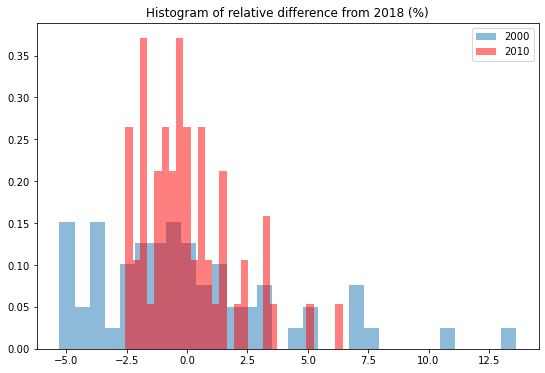

In [112]:
f, ax= plt.subplots(figsize=(9, 6))
plt.hist(diff2000.to_list(),bins=30,density=True,label='2000',alpha=0.5)
plt.hist(diff2010.to_list(),bins=30,density=True,color='r',label='2010',alpha=0.5)
plt.title('Histogram of relative difference from 2018 (%)' )
plt.legend(loc='upper right')
plt.show()

name = 'himalaya_years_hist.png'
#plt.savefig(name, format = 'png')

In [6]:
df = pd.read_hdf(utils.get_demo_file('rgi62_itmix_df.h5'))
df = df.reindex(rgi_ids)

df2=df.drop(labels=['vol_bsl_itmix_m3'],axis=1)
df3=pd.concat([df2,test],axis=1)
df3=df3.assign(diff_rel=((df3['volume_m3']-df3['vol_itmix_m3'])/df3['vol_itmix_m3'])*100)

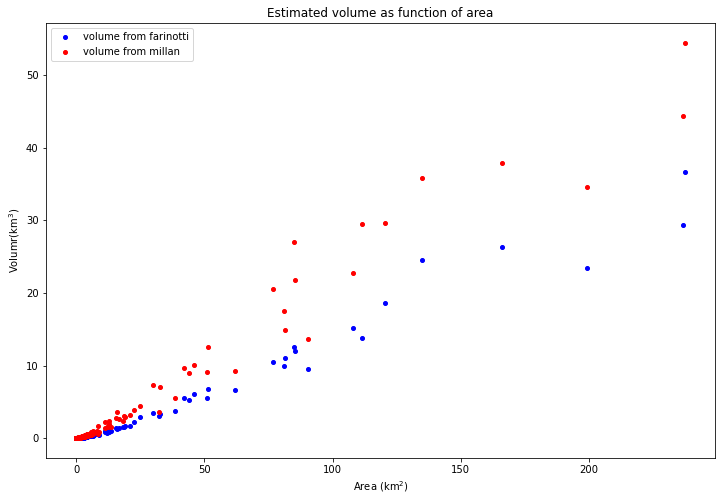

In [17]:
f, ax= plt.subplots(figsize=(12, 8))

x=gdf_sel['Area'].to_list()

plt.plot(x,(df3['vol_itmix_m3']*10**-9).to_list(),'bo',label='volume from farinotti',markersize=4)
plt.plot(x,(df3['volume_m3']*10**-9).to_list(),'ro',label='volume from millan',markersize=4)

plt.legend()          
plt.title('Estimated volume as function of area')
plt.xlabel('Area ($\mathregular{km^2}$)')
plt.ylabel('Volumr($\mathregular{km^3}$)')


name = 'Himalaya_volume-area.png'
plt.savefig(name, format = 'png')

## (1.2) Calibrating the volume on the observations

Before running simulations, we have to examine how evolves the ice thickness along the flowline regarding the original thicknesses from Farinotti or Millan

(this doesn't have to be run again)

In [113]:
import work_tasks


diag=[{'farinotti':[0,0],'millan':[0,0]}]*len(rgi_ids)
eps=[{'farinotti':0,'millan':0}]*len(rgi_ids)
diag_0=[0]*len(rgi_ids)
diag_f=[0]*len(rgi_ids)
diag_m=[0]*len(rgi_ids)

path_to_hdf='/home/lucillegimenes/volumes_millan_13_spe_set_2000.h5'

dff= pd.read_hdf(utils.get_demo_file('rgi62_itmix_df.h5'))
dfm=pd.read_hdf(path_to_hdf)


vreff=[0]*len(rgi_ids)
vrefm=[0]*len(rgi_ids)
vf=[0]*len(rgi_ids)
vm=[0]*len(rgi_ids)

diff=[0]*len(rgi_ids)
difm=[0]*len(rgi_ids)

for data in ['millan','farinotti']:
    print(data)
    gdirs = workflow.init_glacier_directories(rgi_ids,from_prepro_level=3,
                                                  prepro_border=prepro_border)
    
    for gdir in gdirs:
        print(gdir.rgi_id)
        ind=gdirs.index(gdir)
        diag_0[ind]= gdir.get_diagnostics()
        vreff[ind]=dff.loc[gdir.rgi_id,:][0]
        vrefm[ind]=dfm.loc[gdir.rgi_id,:][0]

        if (data=='farinotti'):
            workflow.calibrate_inversion_from_consensus(gdir,apply_fs_on_mismatch=True,error_on_mismatch=False)
            workflow.execute_entity_task(tasks.init_present_time_glacier, gdir)
            diag_f[ind]=gdir.get_diagnostics()
            if 'inversion_glen_a' in diag_f[ind]:
                vf[ind] = tasks.mass_conservation_inversion(gdir, glen_a=diag_f[ind]['inversion_glen_a'], write=False)
                diff[ind]=((vf[ind]-vreff[ind])/vreff[ind])*100

        else:
            work_tasks.calibrate_inversion_from_millan(gdir,path_to_hdf,apply_fs_on_mismatch=True,error_on_mismatch=False,a_bounds=(0.005,10))
            workflow.execute_entity_task(tasks.init_present_time_glacier, gdir)
            diag_m[ind]=gdir.get_diagnostics()
            if 'inversion_glen_a' in diag_m[ind]:
                vm[ind]= tasks.mass_conservation_inversion(gdir, glen_a=diag_m[ind]['inversion_glen_a'], write=False)
                difm[ind]=((vm[ind]-vrefm[ind])/vrefm[ind])*100

        

2021-11-26 16:50:14: oggm.workflow: init_glacier_directories from prepro level 3 on 63 glaciers.
2021-11-26 16:50:14: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 63 glaciers


millan


2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 0.005 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity t

2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 0.005 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity t

RGI60-13.36907
RGI60-13.36908


2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 2.067056723414494 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 1.027481599711828 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.w

2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 4.031870940592501 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 1.7291700194359543 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflo

2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 3.994379747890667 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 1.6995136037825243 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workf

RGI60-13.36920
RGI60-13.36921


2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 0.031169178314548088 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 0.0365448024986332 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.wo

2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 0.02124528314610589 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 0.024824795611813808 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.w

RGI60-13.36925
RGI60-13.37026


2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 0.08548934726922246 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 0.05352480110880979 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:18: og

2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 0.0802402371377828 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 0.042620118568891405 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.work

RGI60-13.37038
RGI60-13.37523


2021-11-26 16:50:18: work_tasks: Consensus estimate optimisation with A factor: 0.4324531376551489 and fs: 0
2021-11-26 16:50:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 0.21872656882757446 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:19: ogg

2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 0.29604404819663865 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 0.27879403216848775 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.work

RGI60-13.37536
RGI60-13.37555


2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 2.845074191702819 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 1.4250370958514094 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.workf

2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 1.3907986191565354 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 0.6978993095782676 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.work

RGI60-13.37566
RGI60-13.37574


2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 2.897517897507616 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 1.451258948753808 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow

2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 1.9793672651665093 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 0.9921836325832546 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workfl

2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 0.14452726496201015 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 0.07476363248100508 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.work

RGI60-13.37587
RGI60-13.37600


2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 0.05026194530104404 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:19: work_tasks: Consensus estimate optimisation with A factor: 0.04796645348780047 and fs: 0
2021-11-26 16:50:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:19: og

2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:20: work_tasks: Consensus estimate optimisation with A factor: 0.02615000871889881 and fs: 0
2021-11-26 16:50:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:20: work_tasks: Consensus estimate optimisation with A factor: 0.025183051260871687 and fs: 0
2021-11-26 16:50:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.wor

RGI60-13.37601
RGI60-13.37602


2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:20: work_tasks: Consensus estimate optimisation with A factor: 0.02763474631637787 and fs: 0
2021-11-26 16:50:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:20: work_tasks: Consensus estimate optimisation with A factor: 0.02652908426641089 and fs: 0
2021-11-26 16:

2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:20: work_tasks: Consensus estimate optimisation with A factor: 0.038392390862494304 and fs: 0
2021-11-26 16:50:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:20: work_ta

RGI60-13.37603
RGI60-13.37604
RGI60-13.37610


2021-11-26 16:50:20: work_tasks: calibration from millan estimate CAN'T converge with fs=0.
Bound values (km3):
Ref=0.575 OGGM=0.538 for A factor 0.005
Ref=0.575 OGGM=0.131 for A factor 10
2021-11-26 16:50:20: work_tasks: We use A factor = 0.005 and fs = 0 and move on.
2021-11-26 16:50:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-26 16:50:20: work_tasks: Consensus estimate optimisation with A factor: 0.005 and fs: 0
2021-11-26 16:50:20: oggm.workflow: Applying global task inve

2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:20: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:20: work_tasks: Consensus estimate optimisation with A factor: 2.1666892935138438 and fs: 0
2021-11-26 16:50:20: oggm.work

RGI60-13.37614
RGI60-13.37615


2021-11-26 16:50:20: work_tasks: Consensus estimate optimisation with A factor: 0.01266595479037903 and fs: 0
2021-11-26 16:50:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:20: work_tasks: calibrate_inversion_from_consensus converged after 11 iterations and fs=0. The resulting Glen A factor is 0.01272960280540606.
2021-11-26 16:50:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [mass_conservatio

2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:20: work_tasks: Consensus estimate optimisation with A factor: 0.15135378500743538 and fs: 0
2021-11-26 16:50:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:20: work_tasks: Consensus estimate optimisation with A factor: 0.07817689250371769 and fs: 0
2021-11-26 16:50:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.work

RGI60-13.37626
RGI60-13.37637
RGI60-13.37640


2021-11-26 16:50:20: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:20: work_tasks: Consensus estimate optimisation with A factor: 5.615269118509521 and fs: 0
2021-11-26 16:50:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:20: oggm.workflow: Exec

2021-11-26 16:50:21: work_tasks: Consensus estimate optimisation with A factor: 2.920454185269514 and fs: 0
2021-11-26 16:50:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:21: work_tasks: Consensus estimate optimisation with A factor: 1.4627270926347569 and fs: 0
2021-11-26 16:50:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.

RGI60-13.37647
RGI60-13.37648


2021-11-26 16:50:21: work_tasks: Consensus estimate optimisation with A factor: 1.6250495553846782 and fs: 0
2021-11-26 16:50:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:21: work_tasks: Consensus estimate optimisation with A factor: 0.815024777692339 and fs: 0
2021-11-26 16:50:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.

2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:21: work_tasks: Consensus estimate optimisation with A factor: 0.7605591446210744 and fs: 0
2021-11-26 16:50:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:21: work_tasks: Consensus estimate optimisation with A factor: 0.3827795723105372 and fs: 0
2021-11-26 16:50:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workfl

RGI60-13.37668
RGI60-13.37682


2021-11-26 16:50:21: work_tasks: Consensus estimate optimisation with A factor: 0.8103341358885209 and fs: 0
2021-11-26 16:50:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:21: work_tasks: Consensus estimate optimisation with A factor: 0.40766706794426044 and fs: 0
2021-11-26 16:50:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:21: ogg

2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:21: work_tasks: Consensus estimate optimisation with A factor: 0.6227507667266441 and fs: 0
2021-11-26 16:50:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:21: work_tasks: Consensus estimate optimisation with A factor: 0.8091611294145071 and fs: 0
2021-11-26 16:50:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workfl

RGI60-13.37713
RGI60-13.37727


2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:21: work_tasks: Consensus estimate optimisation with A factor: 0.22836551899534357 and fs: 0
2021-11-26 16:50:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:21: work_tasks: Consensus estimate optimisation with A factor: 0.33269202314147966 and fs: 0
2021-11-26 16:

2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:21: work_tasks: Consensus estimate optimisation with A factor: 0.3174365142544148 and fs: 0
2021-11-26 16:50:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:21: work_task

RGI60-13.37736
RGI60-13.37751


2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:22: work_tasks: Consensus estimate optimisation with A factor: 0.09078140326499562 and fs: 0
2021-11-26 16:50:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:22: work_tasks: Consensus estimate optimisation with A factor: 0.07570326525773748 and fs: 0
2021-11-26 16:

2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:22: work_tasks: Consensus estimate optimisation with A factor: 0.22023939143615615 and fs: 0
2021-11-26 16:50:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:22: work_tas

RGI60-13.37753
RGI60-13.37775


2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:22: work_tasks: Consensus estimate optimisation with A factor: 0.841802753056251 and fs: 0
2021-11-26 16:50:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:22: work_tasks: Consensus estimate optimisation with A factor: 0.4234013765281255 and fs: 0
2021-11-26 16:50:

2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:22: work_tasks: Consensus estimate optimisation with A factor: 0.6101122939930439 and fs: 0
2021-11-26 16:50:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:22: work_tasks: Consensus estimate optimisation with A factor: 0.5794930879358217 and fs: 0
2021-11-26 16:50

RGI60-13.37779
RGI60-13.37809


2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:22: work_tasks: Consensus estimate optimisation with A factor: 0.030628913616034436 and fs: 0
2021-11-26 16:50:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:22: work_tasks: Consensus estimate optimisation with A factor: 0.020316277729285515 and fs: 0
2021-11-26 1

2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:22: work_tasks: Consensus estimate optimisation with A factor: 0.07196301336144434 and fs: 0
2021-11-26 16:50:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:22: work_tas

RGI60-13.37825
RGI60-13.37842


2021-11-26 16:50:22: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:22: work_tasks: Consensus estimate optimisation with A factor: 4.968786539868368 and fs: 0
2021-11-26 16:50:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:22: oggm.workflow: Exec

2021-11-26 16:50:23: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:23: work_tasks: Consensus estimate optimisation with A factor: 4.7909795989819886 and fs: 0
2021-11-26 16:50:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Exe

2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-26 16:50:23: work_tasks: Consensus estimate optimisation with A factor: 0.005 and fs: 0
2021-11-26 16:50:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:23: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tas

RGI60-13.38334
RGI60-13.53206


2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:23: work_tasks: Consensus estimate optimisation with A factor: 0.11108733180972713 and fs: 0
2021-11-26 16:50:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:23: work_tasks: Consensus estimate optimisation with A factor: 0.05804366590486357 and fs: 0
2021-11-26 16:50:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:23: oggm.wo

2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:23: work_tasks: Consensus estimate optimisation with A factor: 0.008512027585182689 and fs: 0
2021-11-26 16:50:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:23: work_tasks: Consensus estimate optimisation with A factor: 0.008628235372932263 and fs: 0
2021-11-26 1

2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:23: work_tasks: Consensus estimate optimisation with A factor: 0.03600162925569679 and fs: 0


RGI60-13.53207
RGI60-13.53208


2021-11-26 16:50:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:23: work_tasks: Consensus estimate optimisation with A factor: 0.034930643377582095 and fs: 0
2021-11-26 16:50:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow:

2021-11-26 16:50:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:23: work_tasks: Consensus estimate optimisation with A factor: 0.023660685725291442 and fs: 0
2021-11-26 16:50:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow:

RGI60-13.53209
RGI60-13.53218


2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:23: work_tasks: Consensus estimate optimisation with A factor: 0.9008710816245633 and fs: 0
2021-11-26 16:50:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:23: work_tasks: Consensus estimate optimisation with A factor: 0.4635516337339129 and fs: 0
2021-11-26 16:50

2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:23: work_tasks: Consensus estimate optimisation with A factor: 0.005641479800587072 and fs: 0
2021-11-26 16:50:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:23: work_ta

RGI60-13.53221
RGI60-13.53222


2021-11-26 16:50:24: work_tasks: Consensus estimate optimisation with A factor: 0.005 and fs: 0
2021-11-26 16:50:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:24: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity t

2021-11-26 16:50:24: work_tasks: Consensus estimate optimisation with A factor: 5.4541056802708345 and fs: 0
2021-11-26 16:50:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers


RGI60-13.53223
RGI60-13.53230


2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:24: work_tasks: Consensus estimate optimisation with A factor: 2.729552840135417 and fs: 0
2021-11-26 16:50:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:24: work_tasks: Consensus estimate optimisation with A factor: 1.3672764200677086 and fs: 0
2021-11-26 16:50:

2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:24: work_tasks: Consensus estimate optimisation with A factor: 0.2937536439187325 and fs: 0
2021-11-26 16:50:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:24: work_tasks: Consensus estimate optimisation with A factor: 0.11944313337660448 and fs: 0
2021-11-26 16:5

RGI60-13.53234
RGI60-13.53237


2021-11-26 16:50:24: work_tasks: Consensus estimate optimisation with A factor: 0.005 and fs: 0
2021-11-26 16:50:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:24: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity t

2021-11-26 16:50:24: work_tasks: Consensus estimate optimisation with A factor: 0.005 and fs: 0
2021-11-26 16:50:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:24: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:24: oggm.workflow: Execute entity t

RGI60-13.53241
RGI60-13.53242


2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:25: work_tasks: Consensus estimate optimisation with A factor: 0.27273193086309166 and fs: 0
2021-11-26 16:50:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:25: work_tasks: Consensus estimate optimisation with A factor: 0.06356866947067628 and fs: 0
2021-11-26 16:

2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:25: work_tasks: Consensus estimate optimisation with A factor: 0.00625009676795153 and fs: 0
2021-11-26 16:50:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:25: work_tas

RGI60-13.53249
RGI60-13.53655


2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:25: work_tasks: Consensus estimate optimisation with A factor: 0.63955003009216 and fs: 0
2021-11-26 16:50:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:25: work_tasks: Consensus estimate optimisation with A factor: 0.32227501504608 and fs: 0
2021-11-26 16:50:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: 

2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:25: work_tasks: Consensus estimate optimisation with A factor: 0.008563305896783722 and fs: 0
2021-11-26 16:50:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:25: work_tasks: Consensus estimate optimisation with A factor: 0.007292026737036039 and fs: 0
2021-11-26 16:50:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:25: oggm.

RGI60-13.53660
RGI60-13.53668


2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:25: work_tasks: Consensus estimate optimisation with A factor: 0.03901319582156039 and fs: 0
2021-11-26 16:50:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:25: work_tasks: Consensus estimate optimisation with A factor: 0.0248927818678127 and fs: 0
2021-11-26 16:50:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workf

2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:25: work_tasks: Consensus estimate optimisation with A factor: 0.03474357395075529 and fs: 0
2021-11-26 16:50:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:25: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:25: work_tasks: Consensus estimate optimisation with A factor: 0.012987695831730203 and fs: 0
2021-11-26 16:50:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:25: oggm.w

RGI60-13.53671


2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-26 16:50:26: work_tasks: Consensus estimate optimisation with A factor: 0.005 and fs: 0
2021-11-26 16:50:26: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:26: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:26: oggm.workflow: Applying 

RGI60-13.53679


2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:26: work_tasks: calibrate_inversion_from_consensus converged after 12 iterations and fs=0. The resulting Glen A factor is 0.056301526784548764.
2021-11-26 16:50:26: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [init_present_ti

RGI60-13.53689


2021-11-26 16:50:26: work_tasks: Consensus estimate optimisation with A factor: 0.07311783818126083 and fs: 0
2021-11-26 16:50:26: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:26: work_tasks: calibrate_inversion_from_consensus converged after 12 iterations and fs=0. The resulting Glen A factor is 0.07348526450478475.
2021-11-26 16:50:26: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [mass_conservatio

2021-11-26 16:50:26: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:26: work_tasks: Consensus estimate optimisation with A factor: 0.16172143107655146 and fs: 0
2021-11-26 16:50:26: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.core.in

RGI60-13.53696


2021-11-26 16:50:26: work_tasks: calibrate_inversion_from_consensus converged after 11 iterations and fs=0. The resulting Glen A factor is 0.16253410158547885.
2021-11-26 16:50:26: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-26 16:50:26: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-11-26 16:50:26: work_tasks: Consensus estimate optimisation wi

2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:26: work_tasks: calibrate_inversion_from_consensus converged after 12 iterations and fs=0. The resulting Glen A factor is 0.03719307812824595.
2021-11-26 16:50:26: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [init_present_tim

RGI60-13.53711
RGI60-13.53720


2021-11-26 16:50:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:27: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:27: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:27: work_tasks: Consensus estimate optimisation with A factor: 7.299711824588645 and fs: 0
2021-11-26 16:50:27: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:27: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:27: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:27: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:27: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:27: work_tasks: Consensus estimate optimisation with A factor: 3.6523559122943223 and fs: 0
2021-11-26 16:50:

2021-11-26 16:50:27: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:27: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:27: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:27: work_tasks: Consensus estimate optimisation with A factor: 0.2970151332111044 and fs: 0
2021-11-26 16:50:27: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:27: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:27: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:27: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:27: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:27: work_tasks: Consensus estimate optimisation with A factor: 0.11982984277785659 and fs: 0
2021-11-26 16:5

RGI60-13.53722
farinotti


2021-11-26 16:50:27: oggm.workflow: init_glacier_directories from prepro level 3 on 63 glaciers.
2021-11-26 16:50:27: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 63 glaciers
2021-11-26 16:50:31: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-26 16:50:31: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:31: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:31: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:31: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:31: oggm.workflow: A

RGI60-13.36907


2021-11-26 16:50:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:31: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:31: oggm.workflow: Consensus estimate optimisation with A factor: 7.461666014937435 and fs: 0
2021-11-26 16:50:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:31: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:31: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:31: oggm.workflow: Consensus estimate optimisation with A factor: 3.7808330074687175 and fs: 0
2021-11-26 16:50:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:31: oggm

RGI60-13.36908


2021-11-26 16:50:32: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute enti

RGI60-13.36920


2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Consensus estimate optimisation with A factor: 7.155675389534676 and fs: 0
2021-11-26 16:50:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Consensus estimate optimisation with A factor: 3.627837694767338 and fs: 0
2021-11-26 16:50:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:32: oggm.

RGI60-13.36921


2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Consensus estimate optimisation with A factor: 6.703568387083735 and fs: 0
2021-11-26 16:50:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:32: oggm.workflow: Consensus estimate optimisation with A factor: 3.401784193541867 and fs: 0
2021-11-26 1

RGI60-13.36925


2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Consensus estimate optimisation with A factor: 5.810956111337569 and fs: 0
2021-11-26 16:50:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Consensus estimate optimisation with A factor: 2.9554780556687845 and fs: 0
2021-11-26 16:50:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:33: oggm

RGI60-13.37026


2021-11-26 16:50:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Consensus estimate optimisation with A factor: 6.149139980865762 and fs: 0
2021-11-26 16:50:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow:

RGI60-13.37038


2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Consensus estimate optimisation with A factor: 5.912647384848936 and fs: 0
2021-11-26 16:50:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:33: oggm.workflow: Consensus estimate optimisation with A factor: 3.0063236924244676 and fs: 0
2021-11-26 

RGI60-13.37523


2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Consensus estimate optimisation with A factor: 6.702616743145986 and fs: 0
2021-11-26 16:50:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Exe

RGI60-13.37536


2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Consensus estimate optimisation with A factor: 7.149934029451917 and fs: 0
2021-11-26 16:50:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Exe

RGI60-13.37555


2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Consensus estimate optimisation with A factor: 6.319620962379977 and fs: 0
2021-11-26 16:50:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:34: oggm.workflow: Execu

RGI60-13.37566


2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Consensus estimate optimisation with A factor: 5.967674309746557 and fs: 0
2021-11-26 16:50:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:35: oggm.wo

RGI60-13.37574


2021-11-26 16:50:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:35: oggm.workflow: Execute enti

RGI60-13.37587


2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Consensus estimate optimisation with A factor: 6.311456995304534 and fs: 0
2021-11-26 16:50:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Consensus estimate optimisation with A factor: 3.2057284976522666 and fs: 0
2021-11-26 16:50:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:36: oggm

RGI60-13.37600


2021-11-26 16:50:36: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Consensus estimate optimisation with A factor: 6.080659272761137 and fs: 0
2021-11-26 16:50:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow

RGI60-13.37601


2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Consensus estimate optimisation with A factor: 5.429723930352188 and fs: 0
2021-11-26 16:50:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Consensus estimate optimisation with A factor: 2.764861965176094 and fs: 0
2021-11-26 1

RGI60-13.37602


2021-11-26 16:50:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute enti

RGI60-13.37603


2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity t

RGI60-13.37604


2021-11-26 16:50:37: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Consensus estimate optimisation with A factor: 3.560045258661888 and fs: 0
2021-11-26 16:50:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow

RGI60-13.37610


2021-11-26 16:50:37: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:37: oggm.workflow: Execute enti

RGI60-13.37614


2021-11-26 16:50:38: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Consensus estimate optimisation with A factor: 5.892318323521413 and fs: 0
2021-11-26 16:50:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow

RGI60-13.37615


2021-11-26 16:50:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Consensus estimate optimisation with A factor: 2.79240745649086 and fs: 0
2021-11-26 16:50:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: 

RGI60-13.37626


2021-11-26 16:50:38: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:38: oggm.workflow: Execute enti

RGI60-13.37637


2021-11-26 16:50:39: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Consensus estimate optimisation with A factor: 5.984722917250422 and fs: 0
2021-11-26 16:50:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow

RGI60-13.37640


2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Consensus estimate optimisation with A factor: 7.675370006638153 and fs: 0
2021-11-26 16:50:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Exe

RGI60-13.37647


2021-11-26 16:50:39: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Consensus estimate optimisation with A factor: 6.259088465625587 and fs: 0
2021-11-26 16:50:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:39: oggm.workflow

RGI60-13.37648


2021-11-26 16:50:40: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Consensus estimate optimisation with A factor: 7.074801965913856 and fs: 0
2021-11-26 16:50:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow

RGI60-13.37668


2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Consensus estimate optimisation with A factor: 6.6852723047889615 and fs: 0
2021-11-26 16:50:40: ogg

RGI60-13.37682


2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Consensus estimate optimisation with A factor: 6.727772052546744 and fs: 0
2021-11-26 16:50:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:40: oggm.workflow: Exe

RGI60-13.37713


2021-11-26 16:50:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Consensus estimate optimisation with A factor: 6.3419718020946165 and fs: 0
2021-11-26 16:50:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow

RGI60-13.37727


2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Consensus estimate optimisation with A factor: 7.354745044106907 and fs: 0
2021-11-26 16:50:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execu

RGI60-13.37736


2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Consensus estimate optimisation with A factor: 7.1058729528151545 and fs: 0
2021-11-26 16:50:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:41: oggm.workflow: Consensus estimate optimisation with A factor: 3.602936476407577 and fs: 0
2021-11-26 

RGI60-13.37751


2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Consensus estimate optimisation with A factor: 5.582606487042865 and fs: 0
2021-11-26 16:50:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Exe

RGI60-13.37753


2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Consensus estimate optimisation with A factor: 7.426925059224285 and fs: 0
2021-11-26 16:50:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Exe

RGI60-13.37775


2021-11-26 16:50:42: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Consensus estimate optimisation with A factor: 6.87683714884172 and fs: 0
2021-11-26 16:50:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:42: oggm.workflow:

RGI60-13.37779


2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Consensus estimate optimisation with A factor: 7.029684069178241 and fs: 0
2021-11-26 16:50:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Consensus estimate optimisation with A factor: 3.5648420345891205 and fs: 0
2021-11-26 16:50:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:43: oggm

RGI60-13.37809


2021-11-26 16:50:43: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute enti

RGI60-13.37825


2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Consensus estimate optimisation with A factor: 5.924469468260636 and fs: 0
2021-11-26 16:50:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:43: oggm.workflow: Execu

RGI60-13.37842


2021-11-26 16:50:44: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:44: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:44: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Execute enti

RGI60-13.38334


2021-11-26 16:50:44: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:44: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:44: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:44: oggm.workflow: Execute enti

RGI60-13.53206


2021-11-26 16:50:45: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Execute enti

RGI60-13.53207


2021-11-26 16:50:45: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:45: oggm.workflow: Execute enti

RGI60-13.53208


2021-11-26 16:50:46: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:46: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:46: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:46: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:46: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:46: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:46: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:46: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:46: oggm.workflow: Execute enti

RGI60-13.53209


2021-11-26 16:50:47: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Execute enti

RGI60-13.53218


2021-11-26 16:50:47: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:47: oggm.workflow: Execute enti

RGI60-13.53221


2021-11-26 16:50:48: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:48: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:48: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:48: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:48: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:48: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:48: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:48: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:48: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:48: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:48: oggm.workflow: Execute enti

RGI60-13.53222


2021-11-26 16:50:49: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Execute enti

RGI60-13.53223


2021-11-26 16:50:49: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:49: oggm.workflow: Execute enti

RGI60-13.53230


2021-11-26 16:50:50: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:50: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:50: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Execute enti

RGI60-13.53234


2021-11-26 16:50:50: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:50: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:50: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:50: oggm.workflow: Execute enti

RGI60-13.53237


2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:51: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Consensus estimate optimisation with A factor: 6.514992650881964 and fs: 0
2021-11-26 16:50:51: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Exe

RGI60-13.53241


2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Consensus estimate optimisation with A factor: 6.631458979621215 and fs: 0
2021-11-26 16:50:51: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Consensus estimate optimisation with A factor: 3.365729489810607 and fs: 0
2021-11-26 1

RGI60-13.53242


2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Consensus estimate optimisation with A factor: 3.0520128432326556 and fs: 0
2021-11-26 16:50:51: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:51: oggm.workflow: Consensus estimate optimisation with A factor: 1.5760064216163279 and fs: 0
2021-11-26 16:50:51: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:51: ogg

RGI60-13.53249


2021-11-26 16:50:52: oggm.workflow: Consensus estimate optimisation with A factor: 1.1705681181227299 and fs: 0
2021-11-26 16:50:52: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Consensus estimate optimisation with A factor: 0.5948880138590288 and fs: 0
2021-11-26 16:50:52: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:52

RGI60-13.53655


2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Consensus estimate optimisation with A factor: 4.876155629327744 and fs: 0
2021-11-26 16:50:52: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Consensus estimate optimisation with A factor: 2.6714170909261687 and fs: 0
2021-11-26 16:50:52: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:52: oggm.w

RGI60-13.53660


2021-11-26 16:50:52: oggm.workflow: Consensus estimate optimisation with A factor: 0.3313912444786171 and fs: 0
2021-11-26 16:50:52: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Consensus estimate optimisation with A factor: 0.1826483944906947 and fs: 0
2021-11-26 16:50:52: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:52

RGI60-13.53668


2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Consensus estimate optimisation with A factor: 2.6233080372330226 and fs: 0
2021-11-26 16:50:52: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:52: oggm.workflow: Consensus estimate optimisation with A factor: 1.3616540186165114 and fs: 0
2021-11-26 16:50:52: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:52: ogg

RGI60-13.53671


2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Consensus estimate optimisation with A factor: 2.683919914882306 and fs: 0
2021-11-26 16:50:53: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Consensus estimate optimisation with A factor: 1.391959957441153 and fs: 0
2021-11-26 1

RGI60-13.53679


2021-11-26 16:50:53: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Consensus estimate optimisation with A factor: 6.082853299292941 and fs: 0
2021-11-26 16:50:53: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow:

RGI60-13.53689


2021-11-26 16:50:53: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Consensus estimate optimisation with A factor: 3.11384367405882 and fs: 0
2021-11-26 16:50:53: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:53: oggm.workflow: 

RGI60-13.53696


2021-11-26 16:50:54: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:54: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:54: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:54: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:54: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-11-26 16:50:54: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:54: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:54: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:54: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:54: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:54: oggm.workflow: Execute entit

RGI60-13.53711


2021-11-26 16:50:54: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:54: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:54: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:54: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:54: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:54: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:54: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:54: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:54: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:54: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:54: oggm.workflow: Execute enti

RGI60-13.53720


2021-11-26 16:50:55: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:55: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:55: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Execute enti

RGI60-13.53722


2021-11-26 16:50:55: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-26 16:50:55: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-26 16:50:55: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-26 16:50:55: oggm.workflow: Execute enti

### Save the statistics

Also getting rid of all the eventual problematic ones

In [114]:
ind_m=np.array(np.where(np.array(difm)!=0))
ind_f=np.array(np.where(np.array(diff)!=0))


In [115]:
inter= list(set(ind_m.tolist()[0]) & set(ind_f.tolist()[0]))

In [116]:
new_rgi=[0]*len(inter)
for i in range(0,len(inter)):
    new_rgi[i]=rgi_ids[inter[i]]

In [117]:
len(new_rgi)

63

In [118]:
new_spe_set=gdf_sel.loc[gdf_sel['RGIId'].isin(new_rgi)]


In [14]:
new_diag_f=[diag_f[i] for i in inter]
new_diag_f=[new_diag_f[i]['inversion_glen_a'] for i in range(0,len(new_diag_f))]
new_diag_m=[diag_m[i] for i in inter]
new_diag_m=[new_diag_m[i]['inversion_glen_a'] for i in range(0,len(new_diag_m))]

new_diag_0=[diag_0[i] for i in inter]
new_diag_0=[new_diag_0[i]['inversion_glen_a'] for i in range(0,len(new_diag_0))]

new_difm=[difm[i] for i in inter]
new_diff=[diff[i] for i in inter]

In [15]:
#Difference btw calculated volume and the one obtained by OGGM calibration, and the different creep parameters

columns=['eps Farinotti','eps Millan','A OGGM','A Farinotti','A Millan']
index=[new_rgi[0]]
new_data=np.array([[new_diff[0],new_difm[0],new_diag_0[0],
                new_diag_f[0],new_diag_m[0]]])
d_eps=pd.DataFrame(data=new_data,index=index,columns=columns)
d_eps.index.name='RGIId'

for i in range(1,len(new_rgi)):
    index=[new_rgi[i]]
    new_data=np.array([[new_diff[i],new_difm[i],new_diag_0[i],
                new_diag_f[i],new_diag_m[i]]])
    d_eps2=pd.DataFrame(data=new_data,index=index,columns=columns)
    d_eps2.index.name='RGIId'
    new_eps=pd.concat([d_eps,d_eps2],axis=0)
    d_eps=new_eps


In [149]:
new_eps

eps Farinotti  eps Millan        A OGGM   A Farinotti  \
RGIId                                                                   
RGI60-13.36903      -0.003182    1.621038  6.195785e-24  4.333341e-24   
RGI60-13.36904       0.000884   -0.029392  6.195785e-24  2.516338e-24   
RGI60-13.36905       3.054853    4.598678  6.195785e-24  2.904286e-24   
RGI60-13.36906       7.638076    9.387759  6.195785e-24  6.789598e-25   
RGI60-13.36907      -0.005850    0.038197  6.195785e-24  4.811039e-24   
...                       ...         ...           ...           ...   
RGI60-13.53723       5.940392    6.354742  6.195785e-24  3.711236e-25   
RGI60-13.53724       9.118912    9.209943  6.195785e-24  3.047195e-25   
RGI60-13.53726       7.900516  -12.605334  6.195785e-24  6.347249e-24   
RGI60-13.53730       3.415806  -35.919464  6.195785e-24  3.206331e-25   
RGI60-13.53731     170.212374    6.567645  6.195785e-24  2.400000e-25   

                    A Millan  
RGIId                         
RGI60-13.36903  1.360496e-26  
RGI60-13.36904  3.761042e-26  
RGI60-13.36905  1.412744e-26  
RGI60-13.36906  1.254748e-25  
RGI60-13.36907  1.510749e-25  
...                      ...  
RGI60-13.53723  1.229783e-25  
RGI60-13.53724  1.119223e-25  
RGI60-13.53726  1.200000e-26  
RGI60-13.53730  1.200000e-26  
RGI60-13.53731  1.200000e-26  

[442 rows x 5 columns]

In [150]:
store = pd.HDFStore('calibration_13_spe_set.h5')
store.put('dataset_01', new_eps)
store.close()

### Relationship between glen A and glacier area

In [27]:
new_set=gdf_tot.loc[gdf_tot['RGIId'].isin(new_rgi)]

In [28]:
x=new_set['Area'].to_list()

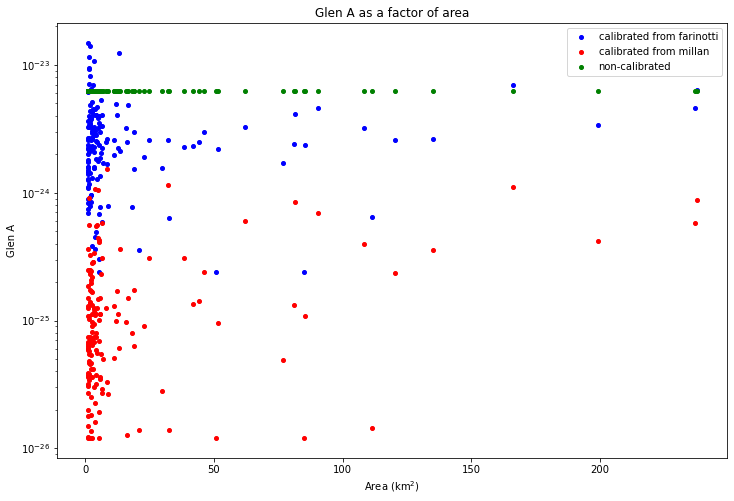

In [61]:
f, ax= plt.subplots(figsize=(12, 8))

plt.plot(x,new_diag_f,'bo',label='calibrated from farinotti',markersize=4)
plt.plot(x,new_diag_m,'ro',label='calibrated from millan',markersize=4)
plt.plot(x,new_diag_0,'go',label= 'non-calibrated',markersize=4)

plt.yscale("log")
plt.legend()          
plt.title('Glen A as a factor of area')
plt.xlabel('Area ($\mathregular{km^2}$)')
plt.ylabel('Glen A')
plt.legend()
name = 'Himalaya_glen_area.png'
plt.savefig(name, format = 'png')

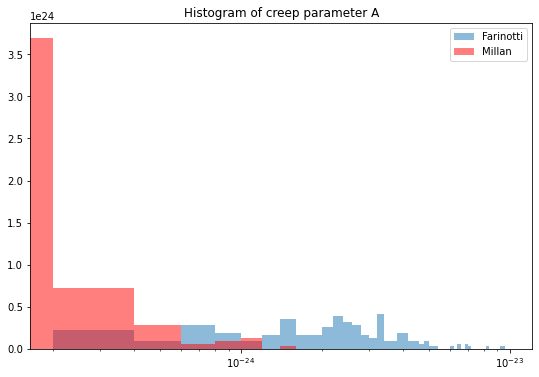

<Figure size 432x288 with 0 Axes>

In [62]:
f, ax= plt.subplots(figsize=(9, 6))
mn=0
mx=1*10**-23
plt.hist(new_diag_f,bins=50,density=True,label='Farinotti',alpha=0.5,range=(mn,mx))
plt.hist(new_diag_m,bins=50,density=True,color='r',label='Millan',alpha=0.5,range=(mn,mx))
plt.xscale("log")
plt.title('Histogram of creep parameter A' )
plt.legend(loc='upper right')
plt.show()
name = 'Himalaya_creep_hist.png'
plt.savefig(name, format = 'png')

### Estimates error within calibration

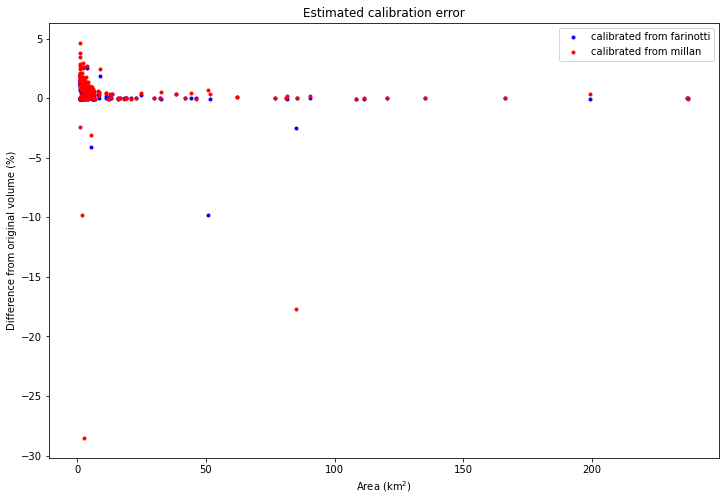

In [234]:
f, ax= plt.subplots(figsize=(12, 8))

plt.plot(x,new_diff,'bo',label='calibrated from farinotti',markersize=3)
plt.plot(x,new_difm,'ro',label='calibrated from millan',markersize=3)

plt.legend()          
plt.title('Estimated calibration error')
plt.xlabel('Area ($\mathregular{km^2}$)')
plt.ylabel('Difference from original volume (%)')
plt.legend()
name = 'Himalaya_estimates_vol.png'
#plt.savefig(name, format = 'png')

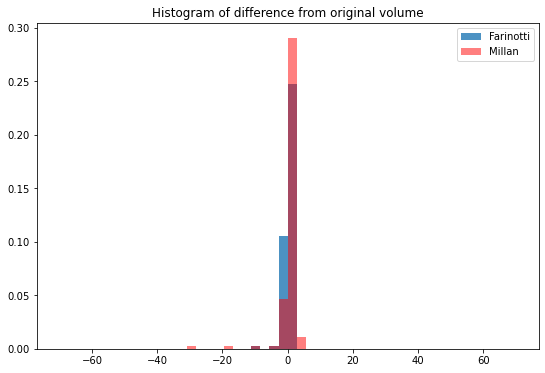

<Figure size 432x288 with 0 Axes>

In [38]:
f, ax= plt.subplots(figsize=(9, 6))

plt.hist(new_diff,bins=50,density=True,label='Farinotti',alpha=0.8,range=(-70,70))
plt.hist(new_difm,bins=50,density=True,color='r',label='Millan',alpha=0.5,range=(-70,70))
plt.title('Histogram of difference from original volume' )
plt.legend(loc='upper right')
plt.show()
name = 'Himalaya_estimates_vol_hist.png'
plt.savefig(name, format = 'png')

## 2. Running simulations based on the calibration

In [6]:
cfg.add_to_basenames('model_geometry_my_spinup','model_geometry_my_spinup.nc')
cfg.add_to_basenames('model_geometry_with_spinup','model_geometry_with_spinup.nc')
cfg.add_to_basenames('model_geometry_no_spinup','model_geometry_no_spinup.nc')
for rcp in ['rcp26','rcp45','rcp60','rcp85']:
    cfg.add_to_basenames('model_geometry_CCSM4_'+rcp+'','model_geometry_CCSM4_'+rcp+'.nc')
    cfg.add_to_basenames('model_diagnostics_CCSM4_'+rcp+'','model_diagnostics_CCSM4_'+rcp+'.nc')

In [15]:
for ssp in ['ssp126','ssp534-over','ssp585']:
    cfg.add_to_basenames('model_geometry_MRI-ESM2-0_'+ssp+'','model_geometry_MRI-ESM2-0_'+ssp+'.nc')
    cfg.add_to_basenames('model_diagnostics_MRI-ESM2-0_'+ssp+'','model_diagnostics_MRI-ESM2-0_'+ssp+'.nc')

ValueError: DocumentedDict accepts only tuple of len 2

In [9]:
#download and process gcm data with RCPs
#precipitations
bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
#temperatures
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'

In [10]:
#download and process gcm data with SSP

bp_s='https://cluster.klima.uni-bremen.de/~oggm/cmip6/GCM/MRI-ESM2-0/MRI-ESM2-0_{}_r1i1p1f1_pr.nc'
bt_s='https://cluster.klima.uni-bremen.de/~oggm/cmip6/GCM/MRI-ESM2-0/MRI-ESM2-0_{}_r1i1p1f1_tas.nc'

In [55]:
import work_tasks
from oggm.core import climate, massbalance, flowline

import time
# start time !
start_time = time.time()

cfg.PARAMS['store_model_geometry'] = True 

#Pre-allocate
out_evol={'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}
out_evol_no_spin = {'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}
out_hydro_hist = {'oggm':0,'farinotti':0,'millan':0}
out_hydro_hist_no_spin = {'oggm':0,'farinotti':0,'millan':0}
d_=[0,0,0]


#Special parameters for calibration 
bounds=(0.005,10)
path_to_hdf='/home/lucillegimenes/volumes_millan_13_spe_set_2000.h5'


k=0
data_list=['oggm','farinotti','millan']
for data in data_list:
    print(data)
    gdirs = workflow.init_glacier_directories(new_rgi,from_prepro_level=from_prepro_level,
                                                  prepro_border=prepro_border)
        
        
    for gdir in gdirs:
        #Calibration
        if (data=='farinotti'):
            work_tasks.calibrate_inversion_from_consensus(gdir,vol_bias=1,apply_fs_on_mismatch=True,error_on_mismatch=False)

        elif(data=='millan'):
            work_tasks.calibrate_inversion_from_millan(gdir,path_to_hdf,vol_bias=1,apply_fs_on_mismatch=True,error_on_mismatch=False,a_bounds=bounds)

        workflow.execute_entity_task(tasks.init_present_time_glacier, gdir)

            #Run the spinup simulation - t* climate    
    workflow.execute_entity_task(tasks.run_constant_climate, gdirs,nyears=200,output_filesuffix='_my_spinup') 

    utils.compile_glacier_statistics(gdirs)
    d_[k] = utils.compile_run_output(gdirs, input_filesuffix='_my_spinup')


            # Run a past climate run based on this spinup
    workflow.execute_entity_task(tasks.run_with_hydro, gdirs, run_task=tasks.run_from_climate_data,
                                        climate_filename='climate_historical',
                                        ys=2003, ye=2020,init_model_filesuffix='_my_spinup',
                                         temperature_bias=5,
                                        output_filesuffix='_with_spinup',store_monthly_hydro=True)
            
    dh=utils.compile_run_output(gdirs, input_filesuffix='_with_spinup') 

    out_hydro_hist[data]=dh
    
    #for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    for ssp in ['ssp126', 'ssp534-over', 'ssp585']:
            # read the path to the files, not opening with xr.opendataset()
        ft = utils.file_downloader(bt_s.format(ssp))
        fp = utils.file_downloader(bp_s.format(ssp))
        

            # bias correct them (filesuffix='_CCSM4_{}' for CMIP5 with RCP)
        workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs, filesuffix='_MRI-ESM2-0_{}'.format(ssp),             # recognize the climate file for later
                                             fpath_temp=ft,                                  # temperature projections
                                             fpath_precip=fp,                                # precip projections
                                             );  


        #projection run (starting from the end year of the historical run)
    #for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    for ssp in ['ssp126', 'ssp534-over', 'ssp585']:
        sid = '_MRI-ESM2-0_{}'.format(ssp)
            # with hydro                                
        workflow.execute_entity_task(tasks.run_with_hydro, gdirs, ys=2020,run_task=tasks.run_from_climate_data,
                                             climate_filename='gcm_data',# use gcm_data, not climate_historical
                                             climate_input_filesuffix=sid, 
                                             temperature_bias=5,# use the chosen scenario
                                             init_model_filesuffix='_with_spinup', # this is important! Start from 2020 glacier
                                             output_filesuffix=sid,                          # recognize the run for later
                                             store_monthly_hydro=True,
                                            );

            # end of the run                                  
        print('Simulation finished sucessfully')

    r=0
    #for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    for ssp in ['ssp126', 'ssp534-over', 'ssp585']:
        sid = '_MRI-ESM2-0_{}'.format(ssp)

        dsf = utils.compile_run_output(gdirs, input_filesuffix=sid) 
            #for later plotting use
        out_evol[data][r]=dsf
        r+=1
        
    k+=1
    
print('Duration is')
print("--- %s seconds ---" % (time.time() - start_time)) 

2021-11-30 16:51:38: oggm.workflow: init_glacier_directories from prepro level 3 on 20 glaciers.


oggm


2021-11-30 16:51:39: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 20 glaciers
2021-11-30 16:51:41: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 16:51:41: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 16:51:41: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 16:51:41: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 16:51:41: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 16:51:41: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 16:51:41: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 16:51:41: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 16:51:41: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 16:51:4

Simulation finished sucessfully


2021-11-30 16:57:21: oggm.workflow: Execute entity tasks [run_with_hydro] on 20 glaciers


Simulation finished sucessfully


2021-11-30 16:59:06: oggm.utils: Applying global task compile_run_output on 20 glaciers
2021-11-30 16:59:06: oggm.utils: Applying compile_run_output on 20 gdirs.


Simulation finished sucessfully


2021-11-30 16:59:06: oggm.utils: Applying global task compile_run_output on 20 glaciers
2021-11-30 16:59:06: oggm.utils: Applying compile_run_output on 20 gdirs.
2021-11-30 16:59:07: oggm.utils: Applying global task compile_run_output on 20 glaciers
2021-11-30 16:59:07: oggm.utils: Applying compile_run_output on 20 gdirs.
2021-11-30 16:59:07: oggm.workflow: init_glacier_directories from prepro level 3 on 20 glaciers.
2021-11-30 16:59:07: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 20 glaciers


farinotti


2021-11-30 16:59:10: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-30 16:59:10: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:10: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:10: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:10: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:10: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:10: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-30 16:59:10: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:10: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:10: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:10: oggm.workflow: Execute entity tas

2021-11-30 16:59:11: work_tasks: Consensus estimate optimisation with A factor: 1.8624835073629793 and fs: 0
2021-11-30 16:59:11: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:11: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:11: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:11: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:11: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:11: work_tasks: Consensus estimate optimisation with A factor: 1.6672966614878066 and fs: 0
2021-11-30 16:59:11: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:11: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:11: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:11: oggm

2021-11-30 16:59:12: work_tasks: calibrate_inversion_from_consensus converged after 8 iterations and fs=0. The resulting Glen A factor is 1.095921029887935.
2021-11-30 16:59:12: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:12: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:12: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:12: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:12: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:12: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 16:59:13: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-30 16:59:13: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:13: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 gla

2021-11-30 16:59:14: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:14: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:14: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:14: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:14: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:14: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:14: work_tasks: calibration from consensus estimate CAN'T converge with fs=0.
Bound values (km3):
Ref=12.633 OGGM=12.321 for A factor 0.1
Ref=12.633 OGGM=4.938 for A factor 10
2021-11-30 16:59:14: work_tasks: We use A factor = 0.1 and fs = 0 and move on.
2021-11-30 16:59:14: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:14: oggm.workflow: Execute entity tasks [prepare_for_inv

2021-11-30 16:59:15: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:15: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:15: work_tasks: Consensus estimate optimisation with A factor: 1.079799962373043 and fs: 0
2021-11-30 16:59:15: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:15: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:15: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:15: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:15: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:15: work_tasks: Consensus estimate optimisation with A factor: 1.072055123231686 and fs: 0
2021-11-30 16:59:15: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:15: oggm.workfl

2021-11-30 16:59:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:17: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:17: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:17: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-30 16:59:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:17: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:17: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:17: work_tasks: Consensus e

2021-11-30 16:59:18: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-30 16:59:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:18: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-30 16:59:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:18: oggm.workflow: Execute entity tas

2021-11-30 16:59:19: work_tasks: Consensus estimate optimisation with A factor: 1.556117367065159 and fs: 0
2021-11-30 16:59:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:19: work_tasks: Consensus estimate optimisation with A factor: 0.8280586835325795 and fs: 0
2021-11-30 16:59:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:19: oggm.

2021-11-30 16:59:20: work_tasks: Consensus estimate optimisation with A factor: 1.0313221789585842 and fs: 0
2021-11-30 16:59:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:20: work_tasks: calibrate_inversion_from_consensus converged after 8 iterations and fs=0. The resulting Glen A factor is 1.0313221789585842.
2021-11-30 16:59:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:20: oggm.workflow: Execute entity tasks [mass_conservation_i

2021-11-30 16:59:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:21: work_tasks: Consensus estimate optimisation with A factor: 3.3416841673460205 and fs: 0
2021-11-30 16:59:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:21: work_tasks: Consensus estimate optimisation with A factor: 1.7208420836730103 and fs: 0
2021-11-30 16:59:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:21: oggm.work

2021-11-30 16:59:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:22: work_tasks: Consensus estimate optimisation with A factor: 0.27630384847371675 and fs: 0
2021-11-30 16:59:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:22: work_tasks: Consensus estimate optimisation with A factor: 0.2697489382889931 and fs: 0
2021-11-30 16:59:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:22: oggm.wor

2021-11-30 16:59:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:23: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 16:59:23: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-30 16:59:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:23: work_tasks: Consensu

2021-11-30 16:59:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:23: work_tasks: Consensus estimate optimisation with A factor: 3.4023403369780807 and fs: 0
2021-11-30 16:59:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:24: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-11-30 16:59:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:24: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:24: work_tasks: Consensus estimate optimisation with A factor: 1.7511701684890404 and fs: 0
2021-11-30 16:59:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:24: oggm.w

2021-11-30 16:59:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:24: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:24: work_tasks: Consensus estimate optimisation with A factor: 2.6945571385716818 and fs: 0
2021-11-30 16:59:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 16:59:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 16:59:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 16:59:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 16:59:24: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 16:59:24: work_tasks: Consensus estimate optimisation with A factor: 2.669939658100078 and fs: 0
2021-11-30 16:59:

Simulation finished sucessfully


2021-11-30 17:05:13: oggm.workflow: Execute entity tasks [run_with_hydro] on 20 glaciers


Simulation finished sucessfully


2021-11-30 17:06:56: oggm.utils: Applying global task compile_run_output on 20 glaciers
2021-11-30 17:06:56: oggm.utils: Applying compile_run_output on 20 gdirs.


Simulation finished sucessfully


2021-11-30 17:06:57: oggm.utils: Applying global task compile_run_output on 20 glaciers
2021-11-30 17:06:57: oggm.utils: Applying compile_run_output on 20 gdirs.
2021-11-30 17:06:57: oggm.utils: Applying global task compile_run_output on 20 glaciers
2021-11-30 17:06:57: oggm.utils: Applying compile_run_output on 20 gdirs.
2021-11-30 17:06:58: oggm.workflow: init_glacier_directories from prepro level 3 on 20 glaciers.


millan


2021-11-30 17:06:58: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 20 glaciers
2021-11-30 17:07:02: work_tasks: Consensus estimate optimisation with A factor: 0.005 and fs: 0
2021-11-30 17:07:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:02: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:02: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:02: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:02: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-30 17:07:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:02: oggm.workflow: Execute entity tasks [mass

2021-11-30 17:07:02: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:02: work_tasks: Consensus estimate optimisation with A factor: 7.079649410923654 and fs: 0
2021-11-30 17:07:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:02: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:02: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:02: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:02: work_tasks: Consensus estimate optimisation with A factor: 3.542324705461827 and fs: 0
2021-11-30 17:07:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:02: oggm.workflow

2021-11-30 17:07:03: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:03: work_tasks: Consensus estimate optimisation with A factor: 1.451258948753808 and fs: 0
2021-11-30 17:07:03: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:03: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:03: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:03: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:03: work_tasks: Consensus estimate optimisation with A factor: 0.7281294743769039 and fs: 0
2021-11-30 17:07:03: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:03: oggm.workflo

2021-11-30 17:07:03: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:03: work_tasks: Consensus estimate optimisation with A factor: 0.5631090598480406 and fs: 0
2021-11-30 17:07:03: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:03: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:03: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:03: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:03: work_tasks: Consensus estimate optimisation with A factor: 0.2840545299240203 and fs: 0
2021-11-30 17:07:03: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:03: oggm.workfl

2021-11-30 17:07:04: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:04: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 17:07:04: work_tasks: Consensus estimate optimisation with A factor: 0.005 and fs: 0
2021-11-30 17:07:04: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:04: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:04: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:04: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:04: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:04: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-30 17:07:04: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:04: oggm.workflow: Execute entity task

2021-11-30 17:07:04: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:04: work_tasks: Consensus estimate optimisation with A factor: 0.1153699636190155 and fs: 0
2021-11-30 17:07:04: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:04: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:04: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:04: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:04: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:04: work_tasks: Consensus estimate optimisation with A factor: 0.11036470333062952 and fs: 0
2021-11-30 17:07:04: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:04: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:04: oggm.workf

2021-11-30 17:07:05: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:05: work_tasks: Consensus estimate optimisation with A factor: 0.17920189486530516 and fs: 0
2021-11-30 17:07:05: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:05: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:05: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:05: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:05: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:05: work_tasks: Consensus estimate optimisation with A factor: 0.17830588538997863 and fs: 0
2021-11-30 17:07:05: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:05: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:05: oggm.work

2021-11-30 17:07:06: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:06: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:06: work_tasks: Consensus estimate optimisation with A factor: 0.31232103558649205 and fs: 0
2021-11-30 17:07:06: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:06: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:06: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:06: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:06: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:06: work_tasks: calibrate_inversion_from_consensus converged after 11 iterations and fs=0. The resulting Glen A factor is 0.3107671995875543.
2021-11-30 17:07:06: oggm.workflow: Applying global task inversion

2021-11-30 17:07:06: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:06: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:06: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:06: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 17:07:06: work_tasks: Consensus estimate optimisation with A factor: 0.005 and fs: 0
2021-11-30 17:07:06: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:06: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:06: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:06: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:06: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:06: work_tasks: Consen

2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 17:07:07: work_tasks: Consensus estimate optimisation with A factor: 0.005 and fs: 0
2021-11-30 17:07:07: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Ex

2021-11-30 17:07:07: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 17:07:07: work_tasks: Consensus estimate optimisation with A factor: 0.005 and fs: 0
2021-11-30 17:07:07: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:07: oggm.workflow: Execute enti

2021-11-30 17:07:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-30 17:07:08: work_tasks: Consensus estimate optimisation with A factor: 0.005 and fs: 0
2021-11-30 17:07:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Execute enti

2021-11-30 17:07:08: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-30 17:07:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:08: work_tasks: Consensus estimate optimisation with A factor: 5.4541056802708345 and fs: 0
2021-11-30 17:07:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:08: oggm.workflow: Exe

2021-11-30 17:07:09: work_tasks: Consensus estimate optimisation with A factor: 0.5433350147265793 and fs: 0
2021-11-30 17:07:09: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:09: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:09: work_tasks: Consensus estimate optimisation with A factor: 0.04227304577514634 and fs: 0
2021-11-30 17:07:09: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:09: ogg

2021-11-30 17:07:09: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:09: work_tasks: Consensus estimate optimisation with A factor: 0.1576407167768923 and fs: 0
2021-11-30 17:07:09: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:09: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:09: work_tasks: Consensus estimate optimisation with A factor: 0.08132035838844615 and fs: 0
2021-11-30 17:07:09: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:09: oggm.workf

2021-11-30 17:07:10: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:10: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:10: work_tasks: Consensus estimate optimisation with A factor: 0.1683328566261077 and fs: 0
2021-11-30 17:07:10: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:10: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:10: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:10: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:10: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:10: work_tasks: Consensus estimate optimisation with A factor: 0.08666642831305385 and fs: 0
2021-11-30 17:07:10: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:10: oggm.wor

2021-11-30 17:07:11: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-11-30 17:07:11: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:11: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:11: work_tasks: Consensus estimate optimisation with A factor: 0.39969181048856156 and fs: 0
2021-11-30 17:07:11: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:11: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:11: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:11: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-11-30 17:07:11: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:11: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:11: work

2021-11-30 17:07:11: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:11: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:11: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:11: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:11: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 17:07:11: work_tasks: Consensus estimate optimisation with A factor: 0.46091948903679025 and fs: 0
2021-11-30 17:07:11: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 17:07:11: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 17:07:11: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 17:07:11: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 17:07:11: oggm.workflow: 

Simulation finished sucessfully


2021-11-30 17:12:31: oggm.workflow: Execute entity tasks [run_with_hydro] on 20 glaciers


Simulation finished sucessfully


2021-11-30 17:13:52: oggm.utils: Applying global task compile_run_output on 20 glaciers
2021-11-30 17:13:52: oggm.utils: Applying compile_run_output on 20 gdirs.


Simulation finished sucessfully


2021-11-30 17:13:53: oggm.utils: Applying global task compile_run_output on 20 glaciers
2021-11-30 17:13:53: oggm.utils: Applying compile_run_output on 20 gdirs.
2021-11-30 17:13:53: oggm.utils: Applying global task compile_run_output on 20 glaciers
2021-11-30 17:13:53: oggm.utils: Applying compile_run_output on 20 gdirs.


Duration is
--- 1334.9023432731628 seconds ---


## 3. Figures

## Influence of the spin up

If the glen parameter A is well adjusted, the spin up shouldn't change much the initial volume

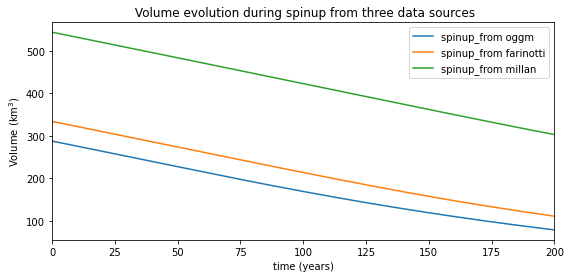

In [124]:
f, ax = plt.subplots(figsize=(9, 4))
for k in range(0,3):
    (d_[k].volume.sum(dim='rgi_id') * 1e-9).plot(ax=ax, label='spinup_from '+data_list[k])

plt.legend()
plt.title(' Volume evolution during spinup from three data sources')
plt.xlabel('time (years)')
plt.ylabel('Volume ($\mathregular{km^3}$)')
plt.xlim([0,200])
name = 'set_himalaya_volume_spinup.png'
plt.savefig(name, format = 'png')

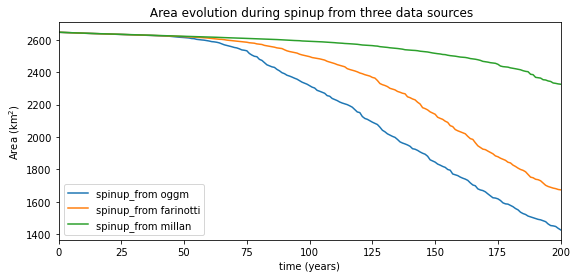

In [125]:
f, ax = plt.subplots(figsize=(9, 4))
for k in range(0,3):
    (d_[k].area.sum(dim='rgi_id') * 1e-6).plot(ax=ax, label='spinup_from '+data_list[k])

plt.legend()
plt.title(' Area evolution during spinup from three data sources')
plt.xlabel('time (years)')
plt.ylabel('Area ($\mathregular{km^2}$)')
plt.xlim([0,200])
name = 'set_himalaya_area_spinup.png'
plt.savefig(name, format = 'png')

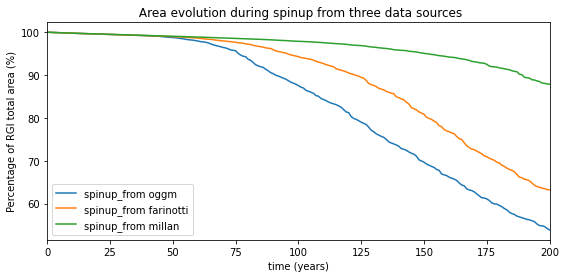

In [131]:
f, ax = plt.subplots(figsize=(9, 4))
tot_aire=sum(x)
for k in range(0,3):
    ((d_[k].area.sum(dim='rgi_id')*10**-6/tot_aire)*100).plot(ax=ax, label='spinup_from '+data_list[k])

plt.legend()
plt.title(' Area evolution during spinup from three data sources')
plt.xlabel('time (years)')
plt.ylabel('Percentage of RGI total area (%)')
plt.xlim([0,200])
name = 'set_himalaya_area_spinup_perc.png'
plt.savefig(name, format = 'png')

## Projected evolution for several SSP

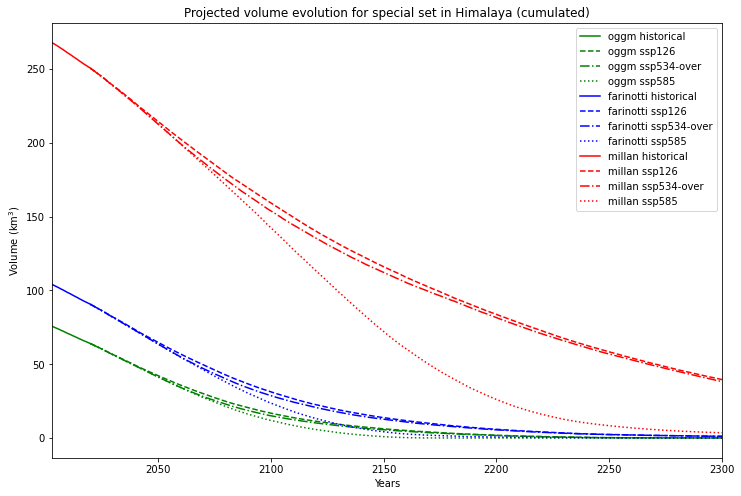

In [19]:
f, ax= plt.subplots(figsize=(12, 8))
ssp=['ssp126', 'ssp534', 'ssp585']


for data in data_list:
    if (data=='farinotti'):
        color_s="b"
    elif(data=='millan'):
        color_s="r"
    else:
        color_s="g"

    (out_hydro_hist[data].sum(dim='rgi_id').volume*10**-9).plot(ax=ax,label=''+data+' historical', linestyle='-',color=color_s)
    for k in range(0,3):
        if (k==0):
            st='dashed'
        elif (k==1):
            st='-.'
        elif (k==2):
            st=':'
        else:
            st=(0, (1, 10))
            
        (out_evol[data][k].sum(dim='rgi_id').volume*10**-9).plot(ax=ax,label=''+data+' '+ssp[k]+'', linestyle=st,color=color_s)

                    
plt.legend()          
plt.title('Projected volume evolution for special set in Himalaya (cumulated)')
plt.xlabel('Years')
plt.xlim([2003,2300])
plt.ylabel('Volume ($\mathregular{km^3}$)')
plt.legend(loc='upper right')
name = 'set_himalaya_evol_volume_ssp.png'
plt.savefig(name, format = 'png')

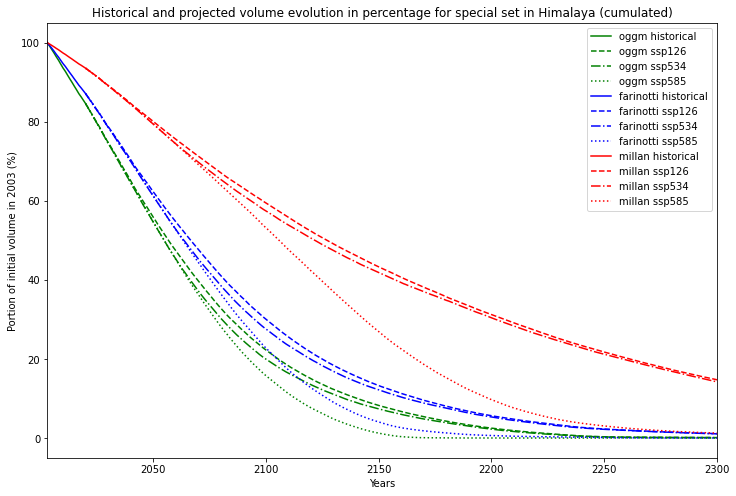

In [23]:
f, ax= plt.subplots(figsize=(12, 8))
ssp=['ssp126', 'ssp534', 'ssp585']


for data in data_list:
    if (data=='farinotti'):
        color_s="b"
    elif(data=='millan'):
        color_s="r"
    else:
        color_s="g"
    
    start_v=np.float64(out_hydro_hist[data].sum(dim='rgi_id').volume.sel(time=[2003]))
    ((out_hydro_hist[data].sum(dim='rgi_id').volume/start_v)*100).plot(ax=ax,label=''+data+' historical', linestyle='-',color=color_s)
    for k in range(0,3):
        if (k==0):
            st='dashed'
        elif (k==1):
            st='-.'
        elif (k==2):
            st=':'
        else:
            st=(0, (1, 10))
            
        ((out_evol[data][k].sum(dim='rgi_id').volume/start_v)*100).plot(ax=ax,label=''+data+' '+ssp[k]+'', linestyle=st,color=color_s)

                    
plt.legend()          
plt.title('Historical and projected volume evolution in percentage for special set in Himalaya (cumulated)')
plt.xlabel('Years')
plt.ylabel('Portion of initial volume in 2003 (%)')
plt.xlim(2003,2300)
name = 'Himalaya_set_volume_perc_ssp.png'
plt.savefig(name, format = 'png')

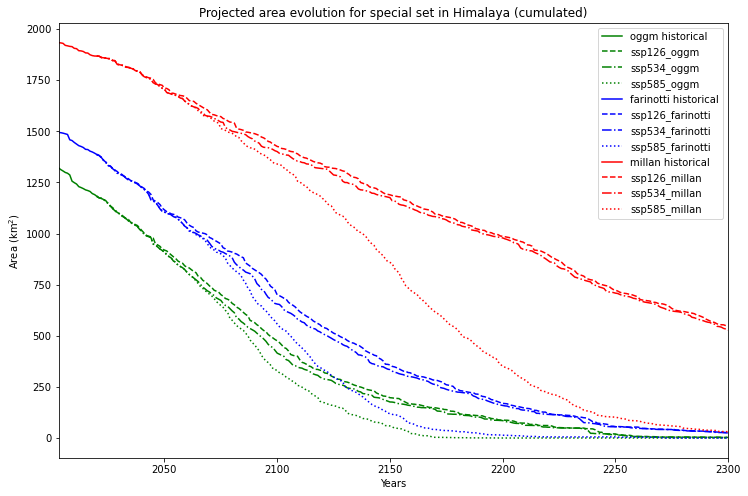

In [28]:
f, ax= plt.subplots(figsize=(12, 8))
ssp=['ssp126', 'ssp534', 'ssp585']


for data in data_list:
    if (data=='farinotti'):
        color_s="b"
    elif(data=='millan'):
        color_s="r"
    else:
        color_s="g"
        
    (out_hydro_hist[data].sum(dim='rgi_id').area*10**-6).plot(ax=ax,label=''+data+' historical', linestyle='-',color=color_s)
    for k in range(0,3):
        if (k==0):
            st='dashed'
        elif (k==1):
            st='-.'
        elif (k==2):
            st=':'
        else:
            st=(0, (1, 10))
            
        (out_evol[data][k].sum(dim='rgi_id').area*10**-6).plot(ax=ax,label=''+ssp[k]+'_'+data, linestyle=st,color=color_s)
        

plt.legend()          
plt.title('Projected area evolution for special set in Himalaya (cumulated)')
plt.xlabel('Years')
plt.ylabel('Area ($\mathregular{km^2}$)')
plt.legend(loc='upper right')
plt.xlim([2003,2300])
name = 'set_himalaya_evol_area_ssp.png'
plt.savefig(name, format = 'png')

### Rate of volume loss

In [30]:

rate={'farinotti':[0]*17,'millan':[0]*17,'oggm':[0]*17}
rate_rcp={'farinotti':[[0]*280,[0]*280,[0]*280,[0]*280],'millan':[[0]*280,[0]*280,[0]*280,[0]*280],
          'oggm':[[0]*280,[0]*280,[0]*280,[0]*280]}
for data in data_list:
    for t in range(2003,2020):
        rate[data][t-2003]=(np.float64(out_hydro_hist[data].sum(dim='rgi_id').volume.sel(time=[t]))-np.float64(out_hydro_hist[data].sum(dim='rgi_id').volume.sel(time=[t+1])))*10**-9
    for k in range(0,3):
        for t in range(2020,2300):
             rate_rcp[data][k][t-2020]=(np.float64(out_evol[data][k].sum(dim='rgi_id').volume.sel(time=[t]))-np.float64(out_evol[data][k].sum(dim='rgi_id').volume.sel(time=[t+1])))*10**-9

In [31]:
rate_all={'farinotti':0,'millan':0,'oggm':0}
for data in data_list:
    rate_all[data]=rate[data]+rate_rcp[data]

In [32]:
t_r=np.linspace(2003,2299,297)

In [33]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

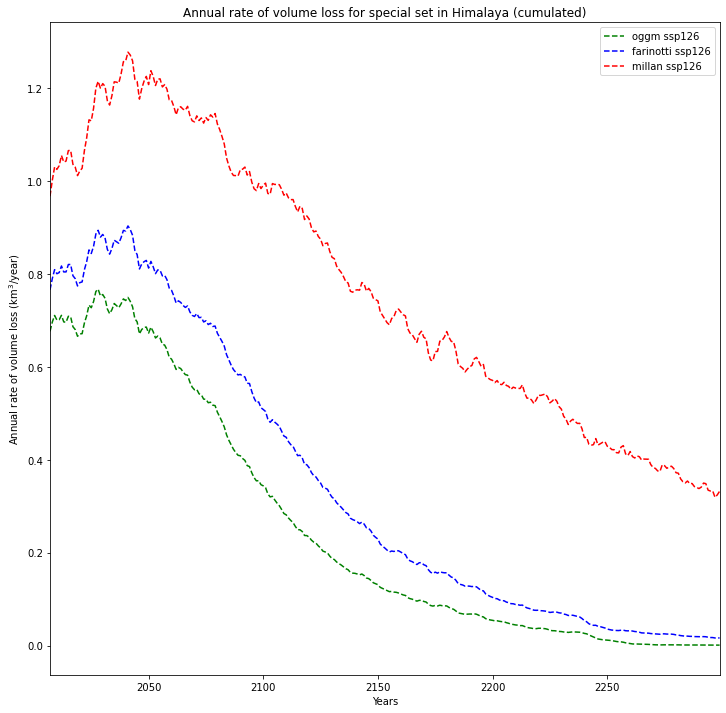

In [39]:
f, ax= plt.subplots(figsize=(12, 12))
ssp=['ssp126', 'ssp534', 'ssp585']

for data in data_list:
    if (data=='farinotti'):
        color_s="b"
    elif(data=='millan'):
        color_s="r"
    else:
        color_s="g"
    
    for k in range(0,3,4):
        if (k==0) or (k==3):
            st='dashed'
        elif (k==1):
            st='-.'
        elif (k==2):
            st=':'
        new_rate=rate_all[data][0:17]+rate_all[data][17+k]
        new_rate=moving_average(new_rate,n=5)
        plt.plot(t_r[4:],new_rate,label=''+data+' '+ssp[k]+'', linestyle=st,color=color_s)

                    
plt.legend() 
plt.xlim(2007,2299)
plt.title('Annual rate of volume loss for special set in Himalaya (cumulated)')
plt.xlabel('Years')
plt.ylabel('Annual rate of volume loss ($\mathregular{km^3}$/year)')
name = 'set_himalaya_rate_vol_lost_126_ssp.png'
plt.savefig(name, format = 'png')

## Annual runoff and peak water 

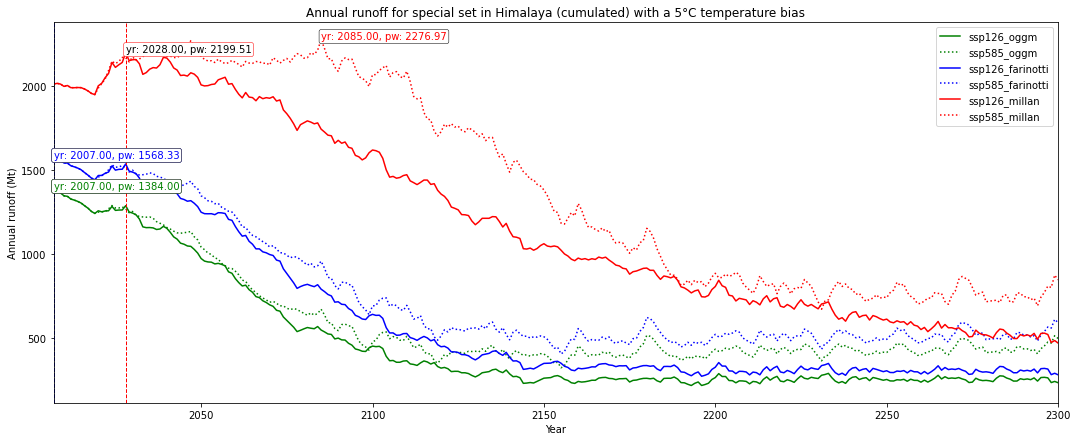

In [56]:
f, ax = plt.subplots(figsize=(18, 7))
ssp=['ssp126', 'ssp534', 'ssp585']

                
for data in data_list: #loop all data sources
    
    for k in range(0,3,2): #loop all scenarios

        # Select annual variables
        d_p=out_evol[data][k].sum(dim='rgi_id')
        d_h=out_hydro_hist[data].sum(dim='rgi_id')

        sel_vars = [v for v in d_p.variables if 'month_2d' not in d_p[v].dims]
        sel_vars_hist = [v for v in d_h.variables if 'month_2d' not in d_h[v].dims]
        
        # And create a dataframe
        dp_annual = d_p[sel_vars].to_dataframe()
        dh_annual = d_h[sel_vars_hist].to_dataframe()

        # Select the variables relevant for runoff.
        runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
        dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
        dp_runoff = dp_runoff.drop([2301],axis=0)
        
        dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
        dh_runoff = dh_runoff.drop([2020],axis=0)
        
        
        dpt_runoff=pd.concat([dh_runoff,dp_runoff], axis=0)
        
        # Sum the variables each year "axis=1", take the 11 year rolling mean
        # and plot it.
        year_pw=int(dpt_runoff.sum(axis=1).rolling(window=5).mean().idxmax())
        max_pw=dpt_runoff.sum(axis=1).rolling(window=5).mean().max()
        
        #Plotting styles
        if (data=='farinotti'):
            color_s='b'
        elif(data=='millan'):
            color_s='r'
        else:
            color_s='g'
        if (k==0):
            st='-'
        elif(k==2):
            st=':'
        
        dpt_runoff.sum(axis=1).rolling(window=5).mean().plot(ax=ax, label=''+ssp[k]+'_'+data, linestyle=st,color=color_s)
        if (k==0):
            plt.axvline(year_pw, color=color_s, linestyle='dashed', linewidth=1)
            plt.text(year_pw, max_pw, 'yr: {:.2f}, '.format(year_pw)+'pw: {:.2f}'.format(max_pw),bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color_s, lw=0.5))
        elif (k==2):
            plt.text(year_pw, max_pw, 'yr: {:.2f}, '.format(year_pw)+'pw: {:.2f}'.format(max_pw),color=color_s,bbox=dict(boxstyle="round,pad=0.2", fc="white", ec='k', lw=0.5))
        
plt.xlim(2007,2300)
ax.set_ylabel('Annual runoff (Mt)')
ax.set_xlabel('Year')
plt.title('Annual runoff for special set in Himalaya (cumulated) with a 5°C temperature bias')
plt.legend();
name = 'set_himalaya_peak_water_ssp_5t'
plt.savefig(name, format = 'png')

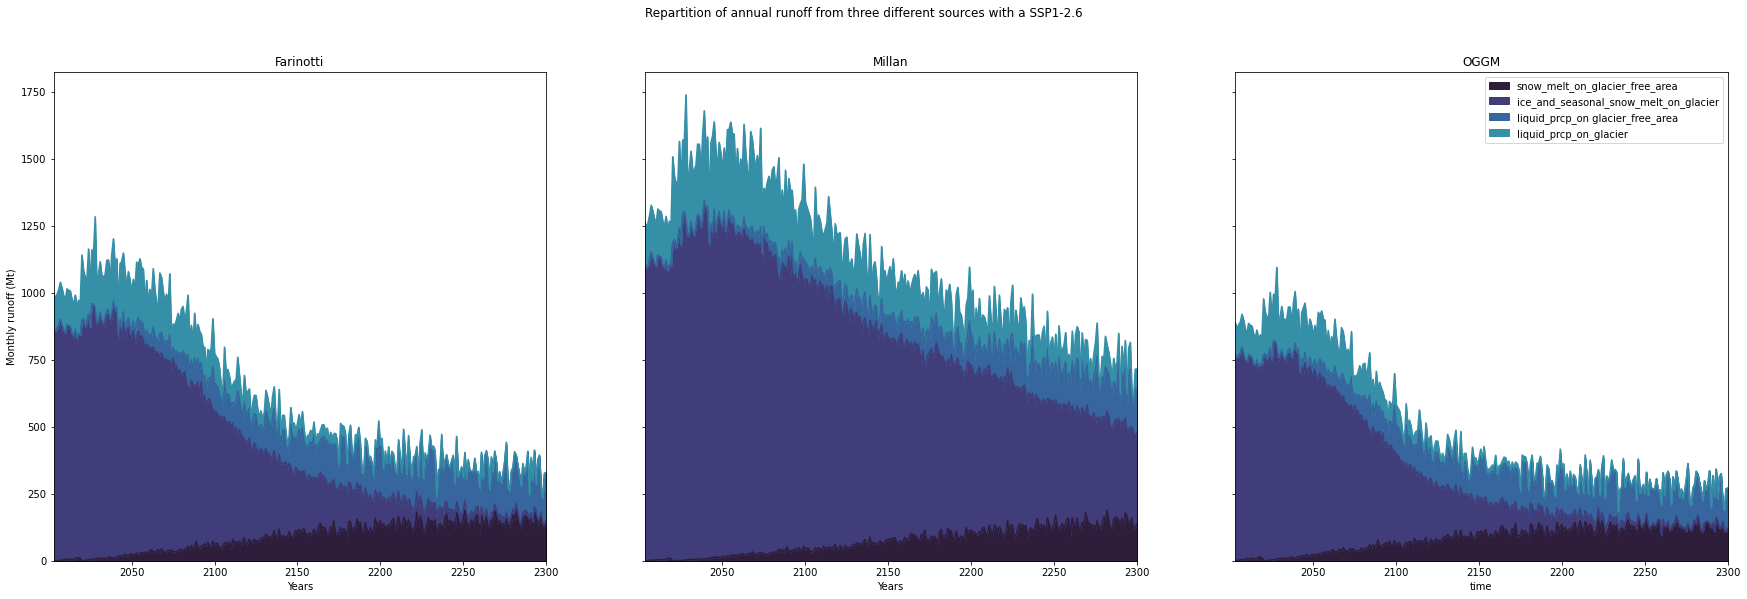

In [47]:
import seaborn as sns
ssp=['ssp126', 'ssp534', 'ssp585']
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(30, 9),sharey=True)

for data in data_list: #loop all data sources
    d_p=out_evol[data][0]
    d_ptot=d_p.sum(dim='rgi_id')
        
    d_h=out_hydro_hist[data]
    d_htot = d_h.sum(dim='rgi_id')

    sel_vars = [v for v in d_ptot.variables if 'month_2d' not in d_ptot[v].dims]
    sel_vars_hist = [v for v in d_htot.variables if 'month_2d' not in d_htot[v].dims]
        
    # And create a dataframe
    dp_annual = d_ptot[sel_vars].to_dataframe()
    dh_annual = d_htot[sel_vars_hist].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
    dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
    dp_runoff = dp_runoff.drop([2301],axis=0)
        
    dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
    dh_runoff = dh_runoff.drop([2020],axis=0)
        
    dp_runoff=pd.concat([dh_runoff,dp_runoff], axis=0) #historical and projections in the same Dataframe
    dp_runoff=dp_runoff.rename(columns={ "melt_off_glacier":"snow_melt_on_glacier_free_area",
                              "melt_on_glacier":"ice_and_seasonal_snow_melt_on_glacier",
                              "liq_prcp_off_glacier":"liquid_prcp_on glacier_free_area",
                              "liq_prcp_on_glacier":"liquid_prcp_on_glacier"})
    
    if (data=='farinotti'):
        dp_runoff.plot.area(ax=ax1, legend=False, title='Farinotti', color=sns.color_palette("mako"));
    elif(data=='millan'):
        dp_runoff.plot.area(ax=ax2, legend=False, title='Millan', color=sns.color_palette("mako")); 
    else:
        dp_runoff.plot.area(ax=ax3, title='OGGM', color=sns.color_palette("mako"));

plt.suptitle('Repartition of annual runoff from three different sources with a SSP1-2.6')
ax1.set_ylabel('Monthly runoff (Mt)'); ax2.set_ylabel('Monthly runoff (Mt)'); ax3.set_ylabel('Monthly runoff (Mt)')
ax1.set_xlabel('Years'); ax2.set_xlabel('Years'); ax3.set_ylabel('Years')
ax1.set_xlim(2003,2300);ax2.set_xlim(2003,2300);ax3.set_xlim(2003,2300)
ax1.set_ylim(bottom=0);ax2.set_ylim(bottom=0);ax3.set_ylim(bottom=0)

name = 'Himalaya_set_distrib_runoff_126_ssp.png'
plt.savefig(name, format = 'png')

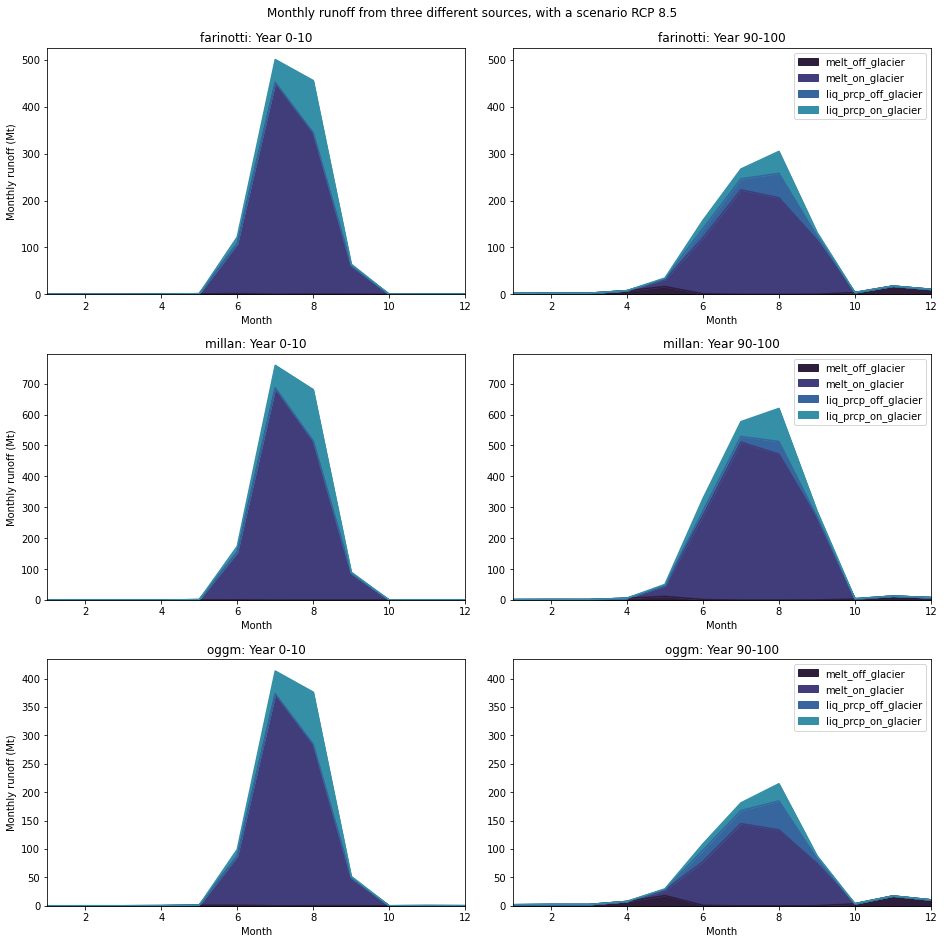

In [247]:
import matplotlib.gridspec as gridspec
fig2 = plt.figure(figsize=(13, 13),constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=2, nrows=3, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[1, 0])
f2_ax4 = fig2.add_subplot(spec2[1, 1])
f2_ax5 = fig2.add_subplot(spec2[2, 0])
f2_ax6 = fig2.add_subplot(spec2[2, 1])



for data in data_list:
    d_p=out_evol[data][3]
    d_ptot=d_p.sum(dim='rgi_id')


    dp_roll=d_ptot.roll(month_2d=d_ptot['calendar_month_2d'].data[0]-1, roll_coords=True)
    dp_roll['month_2d' ] = dp_roll['calendar_month_2d']


    # Pick the variables we need (the 2d ones)
    sel_vars = [v for v in dp_roll.variables if 'month_2d' in dp_roll[v].dims]


    # Pick the first decade and average it
    df_m_s = dp_roll[sel_vars].isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    # Rename the columns for readability
    df_m_s.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
    # Because of floating point precision sometimes runoff can be slightly below zero, clip
    df_m_s = df_m_s.clip(0)

    # Same for end
    df_m_e = dp_roll[sel_vars].isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
    df_m_e = df_m_e.clip(0)
    if (data=='farinotti'):
        axe=f2_ax1
        axe2=f2_ax2
    elif (data=='millan'):
        axe=f2_ax3
        axe2=f2_ax4
    else :
        axe=f2_ax5
        axe2=f2_ax6
    df_m_s[runoff_vars].plot.area(ax=axe, legend=False, title=''+data+': Year 0-10', color=sns.color_palette("mako"));
    df_m_e[runoff_vars].plot.area(ax=axe2, title=''+data+': Year 90-100', color=sns.color_palette("mako"));
    axe.set_ylabel('Monthly runoff (Mt)'); axe.set_xlabel('Month'); axe2.set_xlabel('Month');
    axe.set_xlim(1,12);axe2.set_xlim(1,12)
    a=axe.get_ybound()[1]
    b=axe2.get_ybound()[1]
    mm=max(a,b)
    axe.set_ylim(bottom=0,top=mm);axe2.set_ylim(bottom=0,top=mm)

    
plt.suptitle('Monthly runoff from three different sources, with a scenario RCP 8.5')
name = 'Himalaya_set_monthly_runoff_85.png'
plt.savefig(name, format = 'png')

## Plotting a map of all the glaciers in the region

### Trying to directly create a new grid with the variables from the file

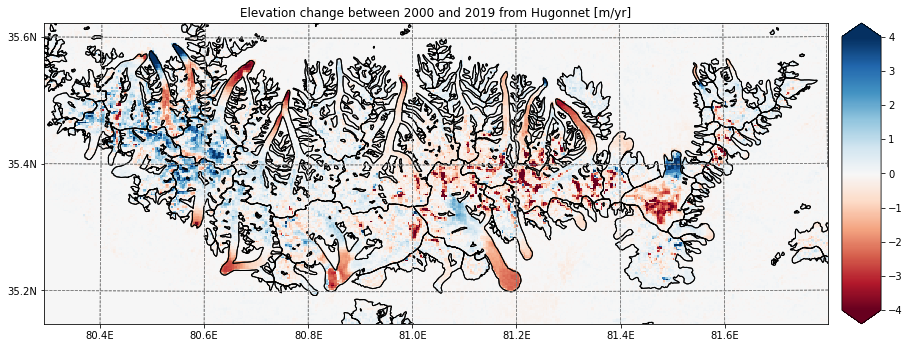

In [7]:
import salem
from salem import Map
from matplotlib import cm as colormap

orig_cmap = matplotlib.cm.RdBu
shifted_cmap2 = graph.shiftedColorMap(orig_cmap, midpoint=0.5, name='shifted')


f, ax= plt.subplots(figsize=(15, 15))

dsb=salem.GeoTiff('/home/lucillegimenes/fusion_set_himalaya_smallproj.tif')
elev = dsb.get_vardata()

sm=Map(dsb.grid, countries=False)
sm.set_shapefile('/home/lucillegimenes/Bureau/RGI/13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp')
sm.set_data(elev)
sm.set_cmap(shifted_cmap2)
sm.plot(ax=ax)
sm.set_vmax(val=4)
sm.set_vmin(val=-4)
sm.visualize(ax=ax,title='Elevation change between 2000 and 2019 from Hugonnet [m/yr]')

name = 'set_himalaya_dh_map.png'
plt.savefig(name, format = 'png')

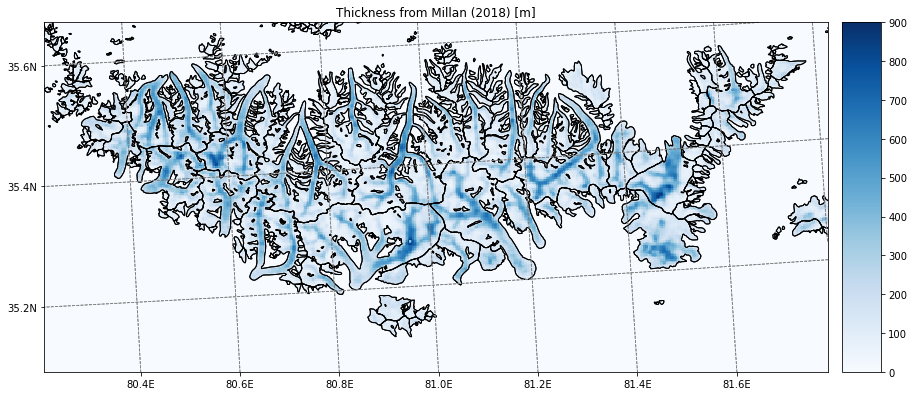

In [13]:
f, ax= plt.subplots(figsize=(15, 15))

dsb=salem.GeoTiff('/home/lucillegimenes/THICKNESS_RGI-13-15_smallproj_test_2.tif')
elev = dsb.get_vardata()

sm=Map(dsb.grid, countries=False)
sm.set_data(elev)
sm.set_shapefile('/home/lucillegimenes/Bureau/RGI/13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp')
sm.set_cmap('Blues')
sm.plot(ax=ax)
sm.set_vmax(val=900)
sm.visualize(ax=ax,title='Thickness from Millan (2018) [m]')

name = 'set_himalaya_millan2018_h_map.png'
plt.savefig(name, format = 'png')

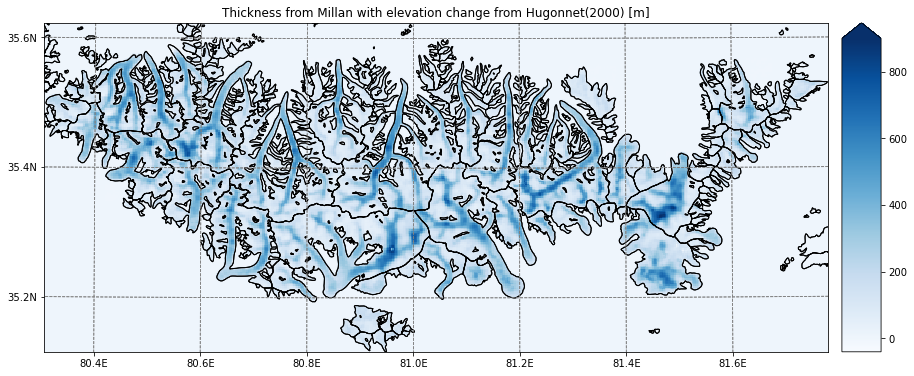

In [14]:
f, ax= plt.subplots(figsize=(15, 15))

dsb=salem.GeoTiff('/home/lucillegimenes/test_fusion_44.tif')
thick = dsb.get_vardata()

sm=Map(dsb.grid, countries=False)
sm.set_data(thick)
sm.set_shapefile('/home/lucillegimenes/Bureau/RGI/13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp')
sm.set_cmap('Blues')
sm.plot(ax=ax)
sm.set_vmax(val=900)
sm.visualize(ax=ax,title='Thickness from Millan with elevation change from Hugonnet(2000) [m]')
name = 'set_himalaya_millan2000_h_map.png'
plt.savefig(name, format = 'png')

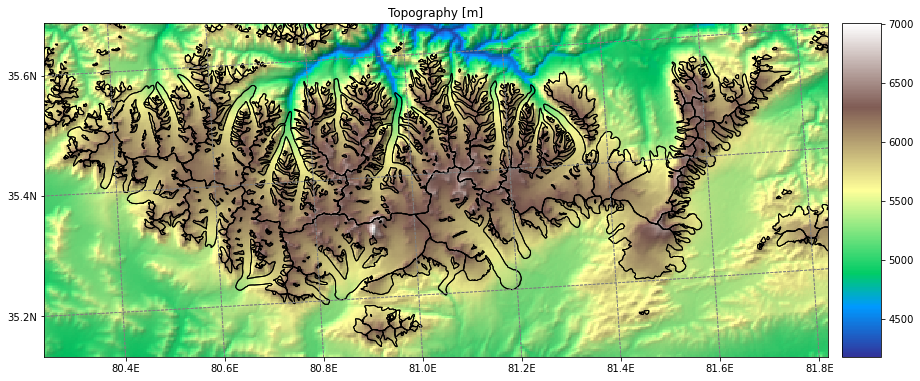

In [31]:
f, ax= plt.subplots(figsize=(15, 15))

dsb=salem.GeoTiff('/home/lucillegimenes/DEM_crop_proj.tif')
topo = dsb.get_vardata()

sm=Map(dsb.grid, countries=False)
sm.set_data(topo)
sm.set_topography(topo);
sm.set_shapefile('/home/lucillegimenes/Bureau/RGI/13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp')
sm.set_cmap('terrain')
sm.plot(ax=ax)
sm.visualize(ax=ax,title='Topography [m]')
name = 'set_himalaya_topo_map.png'
plt.savefig(name, format = 'png')